<a href="https://colab.research.google.com/github/l8518/geot-faas/blob/main/data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [1]:
import datetime
import os
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from notebook_shared import utils

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import Series

import seaborn as sns
sns.set()
matplotlib.style.use('seaborn-colorblind')

INPUT_FILE = "dataset"
FSIZE = "tiny"

df = pd.read_parquet(utils.get_dataset_path(INPUT_FILE, FSIZE))

#   Data Analysis

In [2]:
# dataset = pd.read_parquet('dataset-sampled.parquet')
dataset = df

In [3]:
dataset.columns

Index(['driver_invocation', 'workload_invocation', 'provider', 'region',
       'dirty_measurement', 'folder_uuid', '1_run_id', '2_thread_id',
       'SAAFMemoryDeltaError', 'SAAFMemoryError', 'contextSwitches',
       'contextSwitchesDelta', 'cpuIdle', 'cpuIdleDelta', 'cpuIowait',
       'cpuIowaitDelta', 'cpuIrqDelta', 'cpuKrn', 'cpuKrnDelta', 'cpuModel',
       'cpuNice', 'cpuSoftIrq', 'cpuSoftIrqDelta', 'cpuType', 'cpuUsr',
       'cpuUsrDelta', 'endTime', 'frameworkRuntime', 'frameworkRuntimeDeltas',
       'freeMemory', 'functionName', 'latency', 'linuxVersion', 'newcontainer',
       'roundTripTime', 'runtime', 'runtimeOverlap', 'startTime',
       'totalMemory', 'userRuntime', 'uuid', 'vmcpusteal', 'vmcpustealDelta',
       'vmuptime', 'containerID', 'functionMemory', 'pageFaults',
       'pageFaultsDelta', 'vmID', 'dow_utc', 'tod_utc', 'timezone',
       'measure group', 'local_dow', 'local_tod'],
      dtype='object')

In [4]:
# dataset.groupby( ['driver_invocation', 'provider'])['workload_invocation'].nunique()
# dataset.groupby(['local_tod'])['runtime'].agg(['count'])

coefficient_of_variation = lambda x: np.std(x, ddof=1) / np.mean(x) 

## Measurement Errors (TODO)

In [5]:
measure_target = {'AWS': 10 , 'AZURE': 9 , 'GCP': 10}

In [6]:
measurement_df = dataset.groupby(['driver_invocation', 'provider'])['workload_invocation'].nunique().unstack('provider')

<AxesSubplot:>

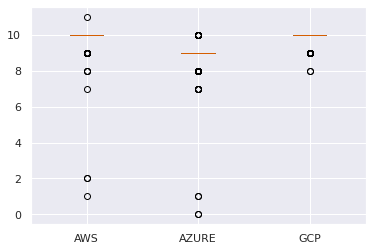

In [7]:
measurement_df.boxplot()

In [8]:
measurement_df[measurement_df['AWS'] > 10]

provider                 AWS  AZURE  GCP
driver_invocation                       
2021-08-04 20:30:04.065   11      9   10

In [9]:
dataset['driver_invocation']

0        2021-08-01 13:30:03.035
1        2021-08-01 13:30:03.035
2        2021-08-01 13:30:03.035
3        2021-08-01 13:30:03.035
4        2021-08-01 13:30:03.035
                   ...          
499531   2021-09-30 23:30:03.438
499532   2021-09-30 23:30:03.438
499533   2021-09-30 23:30:03.438
499534   2021-09-30 23:30:03.438
499535   2021-09-30 23:30:03.438
Name: driver_invocation, Length: 499536, dtype: datetime64[ns]

## Provider Differences

### CPUs

In [10]:
cpu_count_df = dataset.groupby(['measure group', 'provider', 'region', 'driver_invocation'], observed=True)['cpuType'].nunique().reset_index(name='Unique CPU Types')

Average CPU Types used per Invocation
         Unique CPU Types                                             
                    count      mean       std  min  25%  50%  75%  max
provider                                                              
AWS               28927.0  1.039306  0.194325  1.0  1.0  1.0  1.0  2.0
AZURE             25935.0  1.633854  0.607372  1.0  1.0  2.0  2.0  4.0
GCP               29006.0  1.402193  0.524590  1.0  1.0  1.0  2.0  3.0


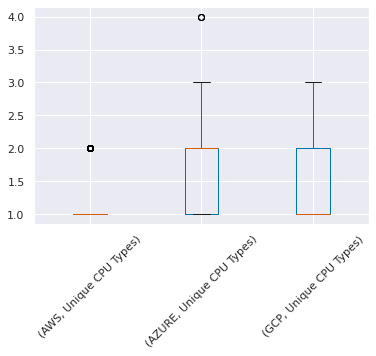

In [11]:
print('Average CPU Types used per Invocation')
cpu_count_df.groupby(['provider']).boxplot(subplots=False, rot=45)
print(cpu_count_df.groupby(['provider']).describe())

Double Schedule + Missing Measurements

## Regional Provider Differences

In [12]:
# Common Stuff
provider_region_mapping = {}
provider_region_mg_df = dataset.groupby( ['provider', 'region'], observed=True)['measure group'].unique().reset_index()
provider_region_mg_df
for index, row in provider_region_mg_df.iterrows():
  for measure_group in row['measure group']:
    region = row['region']
    provider = row['provider']
    measure_group = row['measure group'][0]
    provider_region_mapping[f"({provider}, {region})"] = {'region': region, 'measure group': measure_group, 'provider': provider}
    provider_region_mapping[f"({provider}, {region}, {measure_group})"] = {'region': region, 'measure group': measure_group, 'provider': provider}

### Runtime Mean and CV

In [13]:
measure_group_df = dataset.groupby(['provider', 'region'], observed=True)['measure group'].unique().dropna().reset_index()

In [14]:
cov_provider_region_df = dataset.groupby( ['measure group', 'provider', 'region'], observed=True)['runtime'].apply(coefficient_of_variation).reset_index(name='Runtime CV').set_index(['provider', 'region'])
# mean_provider_region_df = dataset.groupby( ['measure_group', 'provider', 'region'], observed=True)['runtime'].mean().reset_index(name='Runtime Mean').set_index(['provider', 'region'])

AWS


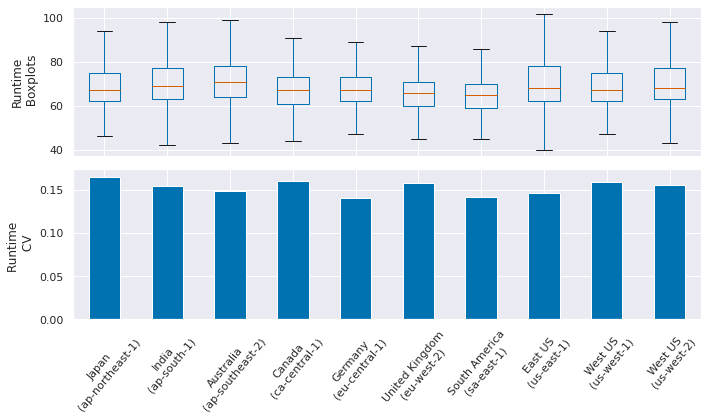

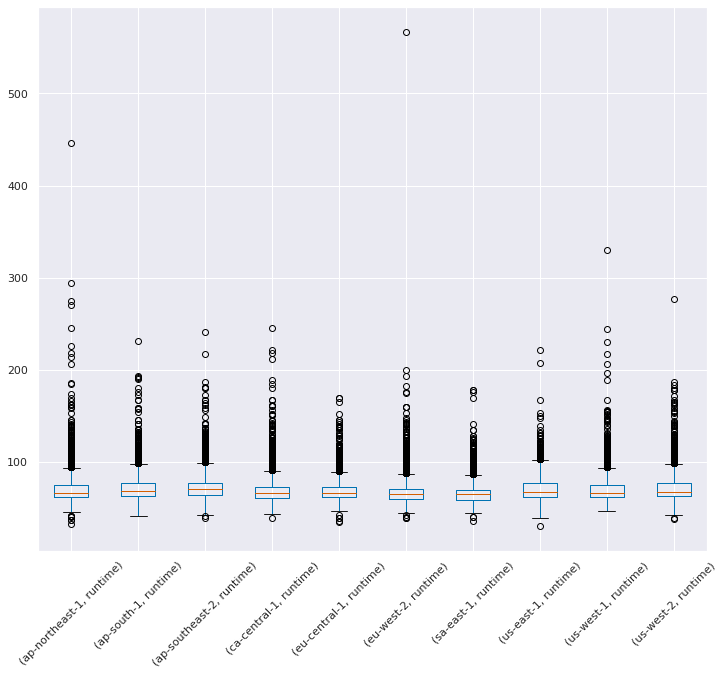

AZURE


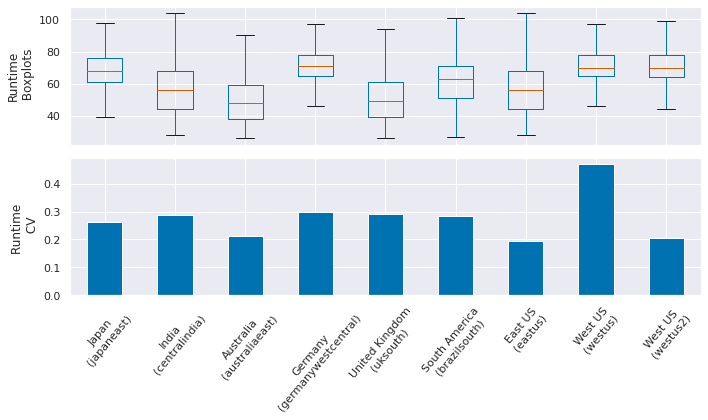

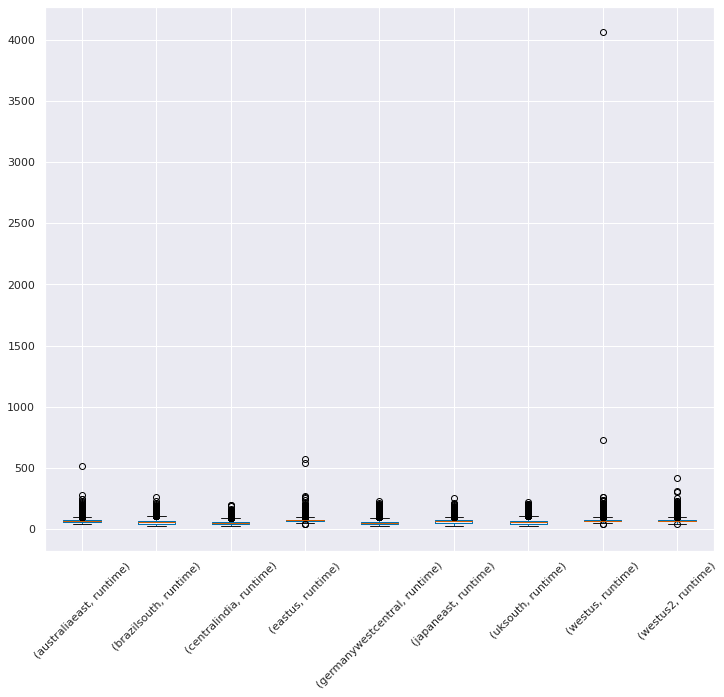

GCP


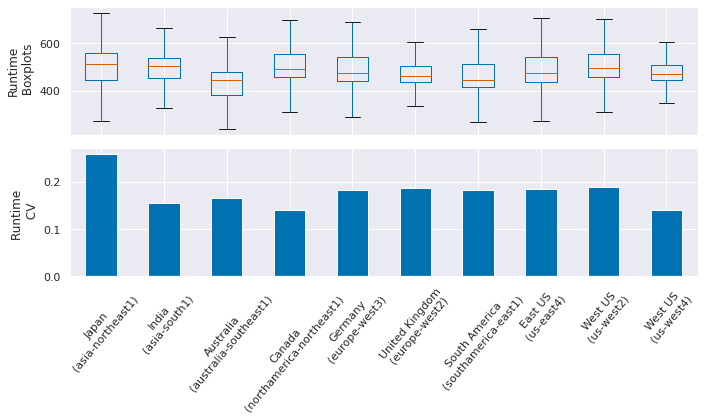

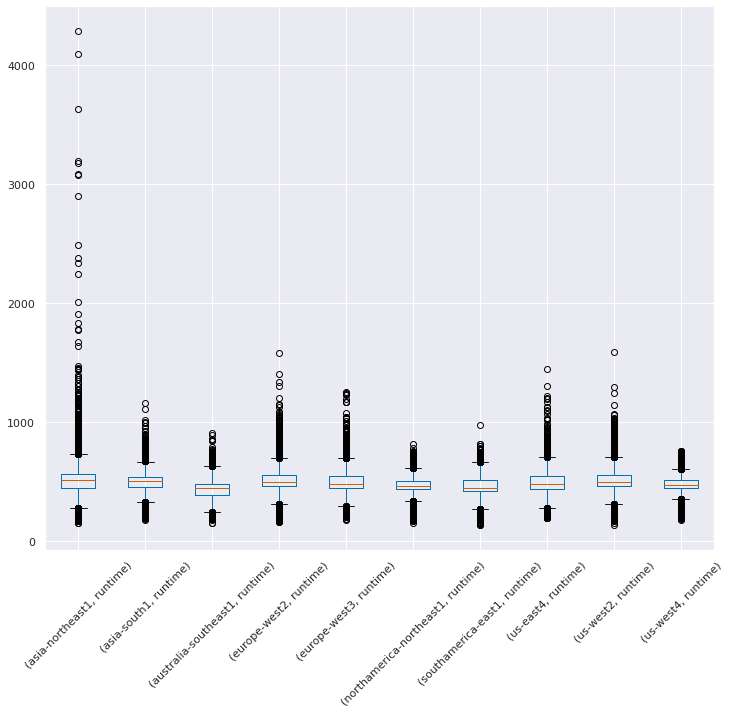

In [15]:
# mean_provider_region_df.sort_values(by=['measure_group', 'provider', 'region'])
cov_provider_region_df.sort_values(by=['measure group', 'provider', 'region'])

for provider in cov_provider_region_df.index.get_level_values('provider').unique():
  fig, axes = plt.subplots(figsize=(10,6), nrows=2, frameon=False)

  #mean_provider_region_df[cov_provider_region_df.index.isin([provider], level='provider')].plot(kind='bar', ax=axes[0])
  dataset[['provider', 'region', 'runtime']][dataset['provider'] == provider].groupby(['region'], observed=True).boxplot(subplots=False, ax=axes[0], showfliers=False)

  cov_provider_region_df[cov_provider_region_df.index.isin([provider], level='provider')].plot(kind='bar', ax=axes[1])

  axes[0].set_ylabel('Runtime\n Boxplots')
  # axes[0].get_legend().remove()
  labels = []
  for tick in axes[0].get_xticklabels():
    labels.append('')
  axes[0].set_xticklabels(labels)

  for tick in axes[1].get_xticklabels():
    tick.set_rotation(50)
  
  # Set Region Names
  labels = []
  for tick in axes[1].get_xticklabels():
    mapping = provider_region_mapping[tick.get_text()]
    region = mapping['region']
    measure_group = mapping['measure group']
    labels.append(f"{measure_group}\n({region})")
  
  axes[1].get_legend().remove()
  axes[1].set_ylabel('Runtime \n CV')
  axes[1].set_xticklabels(labels)
  axes[1].set_xlabel('')


  fig.tight_layout()

  print(provider)
  plt.savefig(f'provider_region_mean_cov_{provider}.pdf')
  plt.show()
  plt.close()

  # Generate a control figure - because I cannot fore the matching
  fig, axes = plt.subplots(figsize=(12,10))
  dataset[['provider', 'region', 'runtime']][dataset['provider'] == provider].groupby(['region'], observed=True).boxplot(subplots=False, ax=axes, rot=45)
  plt.savefig(f'provider_region_mean_cov_{provider}_box.pdf')
  plt.show()
  plt.close()

### Container Ids

In [16]:
uuid_unique_count_df = dataset.groupby(['measure group', 'provider', 'region', 'driver_invocation'], observed=True)['uuid'].nunique().reset_index(name='Unique Container Id')

In [17]:
uuid_unique_count_grouped = dataset.groupby(['measure group', 'provider', 'region', 'driver_invocation'], observed=True)['uuid'].nunique().reset_index(name='Unique Container Id')

In [18]:
uuid_mean_unique_count_df = uuid_unique_count_df.groupby(['measure group', 'provider', 'region'], observed=True)['Unique Container Id'].mean().reset_index(name='Mean Unique Container Id').set_index(['provider', 'region'])
uuid_cv_unique_count_df = uuid_unique_count_df.groupby(['measure group', 'provider', 'region'], observed=True)['Unique Container Id'].apply(coefficient_of_variation).reset_index(name='CV Unique Container Id').set_index(['provider', 'region'])

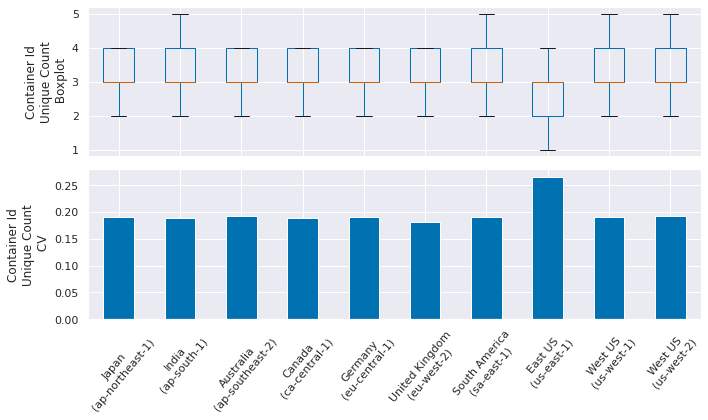

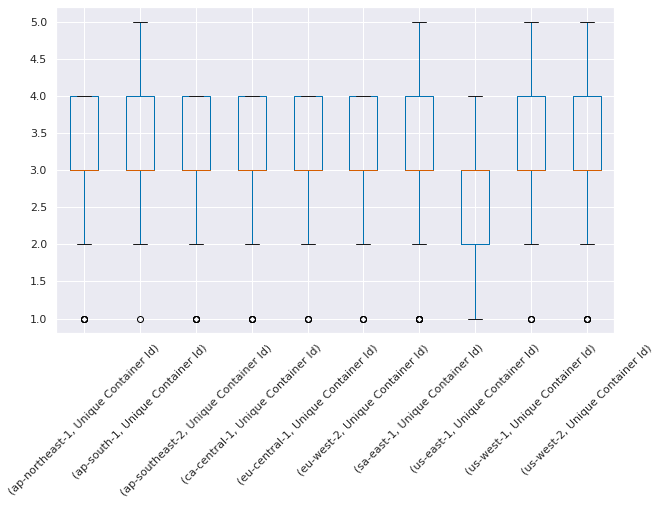

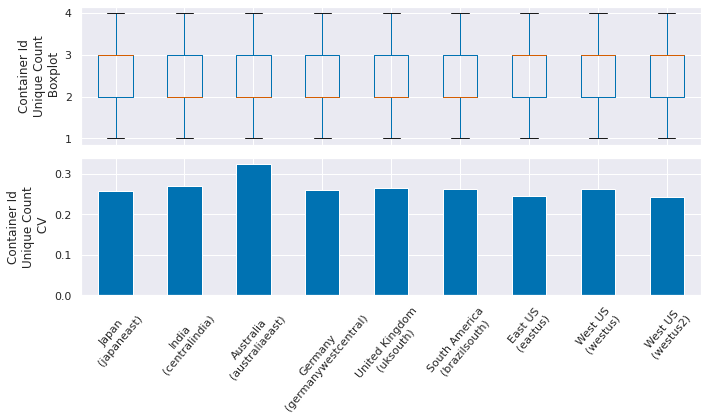

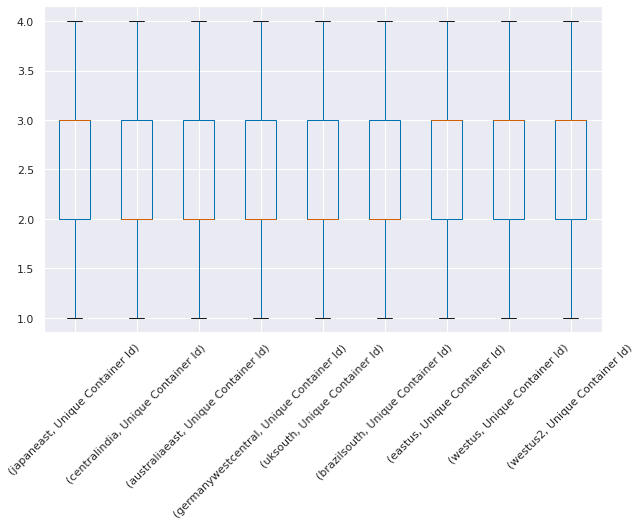

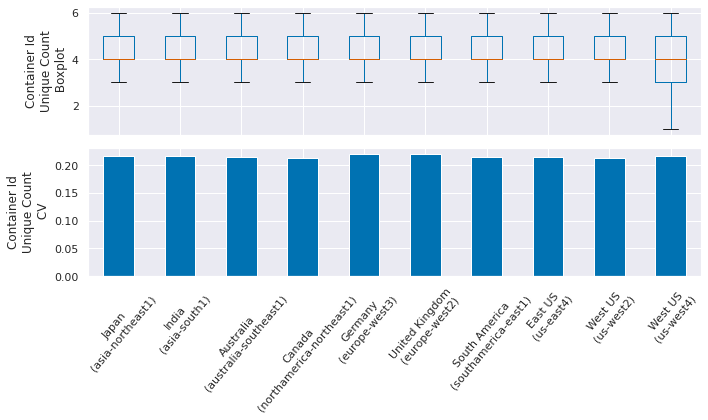

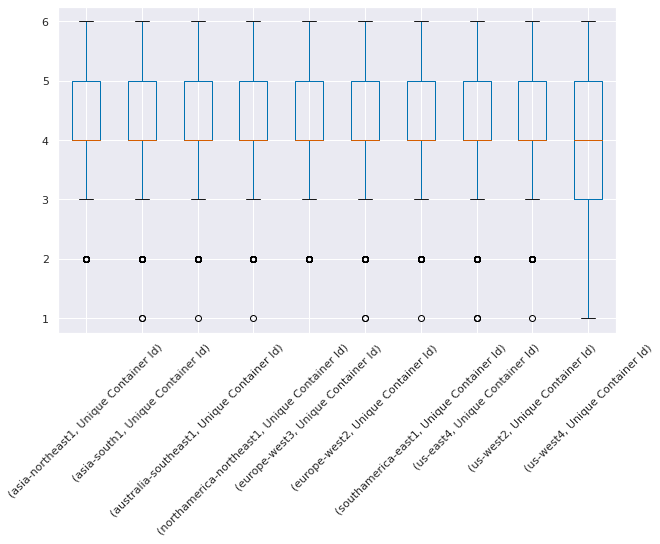

In [19]:
uuid_mean_unique_count_df.sort_values(by=['measure group', 'provider', 'region'])
uuid_cv_unique_count_df.sort_values(by=['measure group', 'provider', 'region'])

for provider in uuid_cv_unique_count_df.index.get_level_values('provider').unique():
  fig, axes = plt.subplots(figsize=(10,6), nrows=2, frameon=False)

  # fig.add_subplot(axsub)
  uuid_unique_count_grouped[uuid_unique_count_grouped['provider'] == provider].groupby(['region'], observed=True).boxplot(subplots=False, ax=axes[0], showfliers=False)
  uuid_cv_unique_count_df[uuid_cv_unique_count_df.index.isin([provider], level='provider')].plot(kind='bar', ax=axes[1])

  axes[0].set_ylabel('Container Id\nUnique Count\n Boxplot')
  labels = []
  for tick in axes[0].get_xticklabels():
    labels.append('')
  axes[0].set_xticklabels(labels)

  # axes[0].get_legend().remove()

  for tick in axes[1].get_xticklabels():
    tick.set_rotation(50)
  
  # Set Region Names
  labels = []
  for tick in axes[1].get_xticklabels():
    mapping = provider_region_mapping[tick.get_text()]
    region = mapping['region']
    measure_group = mapping['measure group']
    labels.append(f"{measure_group}\n({region})")
  
  axes[1].get_legend().remove()
  axes[1].set_ylabel('Container Id\nUnique Count\n CV')
  axes[1].set_xticklabels(labels)
  axes[1].set_xlabel('')


  fig.tight_layout()

  plt.savefig(f'provider_region_container_ids_{provider}.pdf')
  plt.show()
  plt.close()

  # Generate a control figure - because I cannot fore the matching
  fig, axes = plt.subplots(figsize=(10,6))
  uuid_unique_count_grouped[uuid_unique_count_grouped['provider'] == provider].groupby(['region'], observed=True).boxplot(subplots=False, ax=axes, rot=45)
  plt.savefig(f'provider_region_container_ids_{provider}_box.pdf')
  plt.show()
  plt.close()

### CPU types

In [20]:
unique_cpu_types_df = dataset.groupby(['measure group', 'provider', 'region'], observed=True)['cpuType'].unique()
unique_cpu_types_df.to_csv('unique_cpu_types_region_provider', index=False)
unique_cpu_types_df

measure group   provider  region                 
Japan           AWS       ap-northeast-1             ['Intel(R) Xeon(R) Processor @ 2.50GHz - Model...
                AZURE     japaneast                  ['Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz - ...
                GCP       asia-northeast1            ['unknown - Model 85', 'unknown - Model 79', '...
India           AWS       ap-south-1                 ['Intel(R) Xeon(R) Processor @ 2.50GHz - Model...
                AZURE     centralindia               ['Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60G...
                GCP       asia-south1                ['unknown - Model 85']
Categories (9, object):...
Australia       AWS       ap-southeast-2             ['Intel(R) Xeon(R) Processor @ 2.50GHz - Model...
                AZURE     australiaeast              ['Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GH...
                GCP       australia-southeast1       ['unknown - Model 79', 'unknown - Model 85']
C...
Canada          AWS    

In [21]:
unique_cpu_types_count_df = dataset.groupby(['measure group', 'provider', 'region'], observed=True)['cpuType'].nunique()
unique_cpu_types_count_df

measure group   provider  region                 
Japan           AWS       ap-northeast-1             2
                AZURE     japaneast                  4
                GCP       asia-northeast1            3
India           AWS       ap-south-1                 2
                AZURE     centralindia               3
                GCP       asia-south1                1
Australia       AWS       ap-southeast-2             2
                AZURE     australiaeast              4
                GCP       australia-southeast1       2
Canada          AWS       ca-central-1               2
                GCP       northamerica-northeast1    1
Germany         AWS       eu-central-1               2
                AZURE     germanywestcentral         3
                GCP       europe-west3               2
United Kingdom  AWS       eu-west-2                  2
                AZURE     uksouth                    4
                GCP       europe-west2               2
South America  

In [22]:
unique_cpu_types_count_per_invocation_df = dataset.groupby(['measure group', 'provider', 'region', 'driver_invocation'], observed=True)['cpuType'].nunique().reset_index()
unique_cpu_types_count_per_invocation_df.groupby(['provider', 'region']).describe()

cpuType                                     \
                                   count      mean       std  min  25%  50%   
provider region                                                               
AWS      ap-northeast-1           2895.0  1.013126  0.113834  1.0  1.0  1.0   
         ap-south-1               2894.0  1.038701  0.192914  1.0  1.0  1.0   
         ap-southeast-2           2896.0  1.027970  0.164914  1.0  1.0  1.0   
         ca-central-1             2897.0  1.066275  0.248806  1.0  1.0  1.0   
         eu-central-1             2895.0  1.008636  0.092542  1.0  1.0  1.0   
         eu-west-2                2893.0  1.001728  0.041544  1.0  1.0  1.0   
         sa-east-1                2893.0  1.018666  0.135365  1.0  1.0  1.0   
         us-east-1                2885.0  1.134835  0.341607  1.0  1.0  1.0   
         us-west-1                2893.0  1.081922  0.274293  1.0  1.0  1.0   
         us-west-2                2886.0  1.001386  0.037210  1.0  1.0  1.0   
AZURE    australiaeast            2875.0  1.661565  0.608940  1.0  1.0  2.0   
         brazilsouth              2878.0  1.773454  0.614474  1.0  1.0  2.0   
         centralindia             2895.0  1.338515  0.476923  1.0  1.0  1.0   
         eastus                   2871.0  1.935563  0.588827  1.0  2.0  2.0   
         germanywestcentral       2897.0  1.489472  0.516285  1.0  1.0  1.0   
         japaneast                2894.0  1.747754  0.595484  1.0  1.0  2.0   
         uksouth                  2893.0  1.751469  0.608920  1.0  1.0  2.0   
         westus                   2836.0  1.820522  0.594402  1.0  1.0  2.0   
         westus2                  2896.0  1.194061  0.424198  1.0  1.0  1.0   
GCP      asia-northeast1          2900.0  1.953793  0.625934  1.0  2.0  2.0   
         asia-south1              2901.0  1.000000  0.000000  1.0  1.0  1.0   
         australia-southeast1     2901.0  1.802827  0.397933  1.0  2.0  2.0   
         europe-west2             2901.0  1.084454  0.278115  1.0  1.0  1.0   
         europe-west3             2901.0  1.685281  0.464484  1.0  1.0  2.0   
         northamerica-northeast1  2901.0  1.000000  0.000000  1.0  1.0  1.0   
         southamerica-east1       2900.0  1.860000  0.347047  1.0  2.0  2.0   
         us-east4                 2901.0  1.635643  0.481332  1.0  1.0  2.0   
         us-west2                 2900.0  1.000000  0.000000  1.0  1.0  1.0   
         us-west4                 2900.0  1.000000  0.000000  1.0  1.0  1.0   

                                            
                                  75%  max  
provider region                             
AWS      ap-northeast-1           1.0  2.0  
         ap-south-1               1.0  2.0  
         ap-southeast-2           1.0  2.0  
         ca-central-1             1.0  2.0  
         eu-central-1             1.0  2.0  
         eu-west-2                1.0  2.0  
         sa-east-1                1.0  2.0  
         us-east-1                1.0  2.0  
         us-west-1                1.0  2.0  
         us-west-2                1.0  2.0  
AZURE    australiaeast            2.0  3.0  
         brazilsouth              2.0  4.0  
         centralindia             2.0  3.0  
         eastus                   2.0  3.0  
         germanywestcentral       2.0  3.0  
         japaneast                2.0  3.0  
         uksouth                  2.0  4.0  
         westus                   2.0  3.0  
         westus2                  1.0  3.0  
GCP      asia-northeast1          2.0  3.0  
         asia-south1              1.0  1.0  
         australia-southeast1     2.0  2.0  
         europe-west2             1.0  2.0  
         europe-west3             2.0  2.0  
         northamerica-northeast1  1.0  1.0  
         southamerica-east1       2.0  2.0  
         us-east4                 2.0  2.0  
         us-west2                 1.0  1.0  
         us-west4                 1.0  1.0

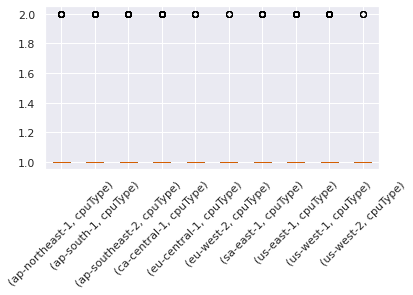

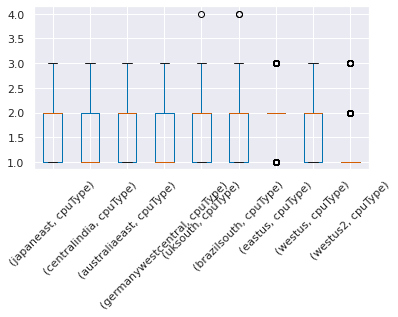

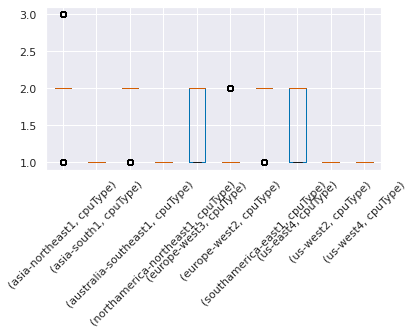

In [23]:
# Boxplots over CPUs per Invocation
for provider in unique_cpu_types_count_per_invocation_df['provider'].unique():
  fig, axes = plt.subplots(figsize=(6,3), nrows=1, ncols=1, frameon=False)
  unique_cpu_types_count_per_invocation_df[unique_cpu_types_count_per_invocation_df['provider'] == provider].groupby('region', observed=True).boxplot(subplots=False, rot=45, ax=axes)
  plt.savefig(f'unique_cpu_types_count_per_invocation_{provider}_box.pdf')
  plt.show()
  plt.close()

### Correlation Stuff - is that even possible?!

In [24]:
regional_provider_differences = dataset[ ['provider', 'region', 'runtime', 'driver_invocation'] ]
regional_provider_differences_avg_runtime = regional_provider_differences.groupby(['provider', 'region', 'driver_invocation'],observed=True).mean().reset_index()

In [25]:
regional_provider_differences_avg_runtime

provider          region       driver_invocation     runtime
0          AWS  ap-northeast-1 2021-08-01 13:30:03.035   65.333333
1          AWS  ap-northeast-1 2021-08-01 14:00:04.366        71.5
2          AWS  ap-northeast-1 2021-08-01 14:30:02.838   74.166667
3          AWS  ap-northeast-1 2021-08-01 15:00:04.119   72.166667
4          AWS  ap-northeast-1 2021-08-01 15:30:04.040        73.5
...        ...             ...                     ...         ...
83863      GCP        us-west4 2021-09-30 21:30:04.350  455.333333
83864      GCP        us-west4 2021-09-30 22:00:04.183  405.833333
83865      GCP        us-west4 2021-09-30 22:30:03.646       446.5
83866      GCP        us-west4 2021-09-30 23:00:03.864       487.5
83867      GCP        us-west4 2021-09-30 23:30:03.438  445.666667

[83868 rows x 4 columns]

In [26]:
region_dummies = pd.get_dummies(regional_provider_differences_avg_runtime, prefix=['region'], columns=['region'])

In [27]:
region_dummies

provider       driver_invocation     runtime  region_ap-northeast-1  \
0          AWS 2021-08-01 13:30:03.035   65.333333                      1   
1          AWS 2021-08-01 14:00:04.366        71.5                      1   
2          AWS 2021-08-01 14:30:02.838   74.166667                      1   
3          AWS 2021-08-01 15:00:04.119   72.166667                      1   
4          AWS 2021-08-01 15:30:04.040        73.5                      1   
...        ...                     ...         ...                    ...   
83863      GCP 2021-09-30 21:30:04.350  455.333333                      0   
83864      GCP 2021-09-30 22:00:04.183  405.833333                      0   
83865      GCP 2021-09-30 22:30:03.646       446.5                      0   
83866      GCP 2021-09-30 23:00:03.864       487.5                      0   
83867      GCP 2021-09-30 23:30:03.438  445.666667                      0   

       region_ap-south-1  region_ap-southeast-2  region_asia-northeast1  \
0                      0                      0                       0   
1                      0                      0                       0   
2                      0                      0                       0   
3                      0                      0                       0   
4                      0                      0                       0   
...                  ...                    ...                     ...   
83863                  0                      0                       0   
83864                  0                      0                       0   
83865                  0                      0                       0   
83866                  0                      0                       0   
83867                  0                      0                       0   

       region_asia-south1  region_australia-southeast1  region_australiaeast  \
0                       0                            0                     0   
1                       0                            0                     0   
2                       0                            0                     0   
3                       0                            0                     0   
4                       0                            0                     0   
...                   ...                          ...                   ...   
83863                   0                            0                     0   
83864                   0                            0                     0   
83865                   0                            0                     0   
83866                   0                            0                     0   
83867                   0                            0                     0   

       ...  region_southamerica-east1  region_uksouth  region_us-east-1  \
0      ...                          0               0                 0   
1      ...                          0               0                 0   
2      ...                          0               0                 0   
3      ...                          0               0                 0   
4      ...                          0               0                 0   
...    ...                        ...             ...               ...   
83863  ...                          0               0                 0   
83864  ...                          0               0                 0   
83865  ...                          0               0                 0   
83866  ...                          0               0                 0   
83867  ...                          0               0                 0   

       region_us-east4  region_us-west-1  region_us-west-2  region_us-west2  \
0                    0                 0                 0                0   
1                    0                 0                 0                0   
2                    0                 0                 0                0   
3 

In [28]:
df = pd.concat( [regional_provider_differences_avg_runtime, region_dummies] , axis=1)
df

provider          region       driver_invocation     runtime provider  \
0          AWS  ap-northeast-1 2021-08-01 13:30:03.035   65.333333      AWS   
1          AWS  ap-northeast-1 2021-08-01 14:00:04.366        71.5      AWS   
2          AWS  ap-northeast-1 2021-08-01 14:30:02.838   74.166667      AWS   
3          AWS  ap-northeast-1 2021-08-01 15:00:04.119   72.166667      AWS   
4          AWS  ap-northeast-1 2021-08-01 15:30:04.040        73.5      AWS   
...        ...             ...                     ...         ...      ...   
83863      GCP        us-west4 2021-09-30 21:30:04.350  455.333333      GCP   
83864      GCP        us-west4 2021-09-30 22:00:04.183  405.833333      GCP   
83865      GCP        us-west4 2021-09-30 22:30:03.646       446.5      GCP   
83866      GCP        us-west4 2021-09-30 23:00:03.864       487.5      GCP   
83867      GCP        us-west4 2021-09-30 23:30:03.438  445.666667      GCP   

            driver_invocation     runtime  region_ap-northeast-1  \
0     2021-08-01 13:30:03.035   65.333333                      1   
1     2021-08-01 14:00:04.366        71.5                      1   
2     2021-08-01 14:30:02.838   74.166667                      1   
3     2021-08-01 15:00:04.119   72.166667                      1   
4     2021-08-01 15:30:04.040        73.5                      1   
...                       ...         ...                    ...   
83863 2021-09-30 21:30:04.350  455.333333                      0   
83864 2021-09-30 22:00:04.183  405.833333                      0   
83865 2021-09-30 22:30:03.646       446.5                      0   
83866 2021-09-30 23:00:03.864       487.5                      0   
83867 2021-09-30 23:30:03.438  445.666667                      0   

       region_ap-south-1  region_ap-southeast-2  ...  \
0                      0                      0  ...   
1                      0                      0  ...   
2                      0                      0  ...   
3                      0                      0  ...   
4                      0                      0  ...   
...                  ...                    ...  ...   
83863                  0                      0  ...   
83864                  0                      0  ...   
83865                  0                      0  ...   
83866                  0                      0  ...   
83867                  0                      0  ...   

       region_southamerica-east1  region_uksouth  region_us-east-1  \
0                              0               0                 0   
1                              0               0                 0   
2                              0               0                 0   
3                              0               0                 0   
4                              0               0                 0   
...                          ...             ...               ...   
83863                          0               0                 0   
83864                          0               0                 0   
83865                          0               0                 0   
83866                          0               0                 0   
83867                          0               0                 0   

       region_us-east4  region_us-west-1  region_us-west-2  region_us-west2  \
0                    0                 0                 0                0   
1                    0                 0                 0                0   
2                    0                 0                 0                0   
3                    0                 0                 0                0   
4                    0                 0                 0                0   
...                ...               ...               ...              ...   
83863                0                 0                 0                0   
83864                0                 0                 0                0   
83865          

In [29]:
df.corr()

runtime   runtime  region_ap-northeast-1  \
runtime                         1.000000  1.000000              -0.132100   
runtime                         1.000000  1.000000              -0.132100   
region_ap-northeast-1          -0.132100 -0.132100               1.000000   
region_ap-south-1              -0.130896 -0.130896              -0.035746   
region_ap-southeast-2          -0.130545 -0.130545              -0.035759   
region_asia-northeast1          0.284839  0.284839              -0.035785   
region_asia-south1              0.277605  0.277605              -0.035791   
region_australia-southeast1     0.213384  0.213384              -0.035791   
region_australiaeast           -0.131164 -0.131164              -0.035625   
region_brazilsouth             -0.143234 -0.143234              -0.035644   
region_ca-central-1            -0.133478 -0.133478              -0.035765   
region_centralindia            -0.150572 -0.150572              -0.035753   
region_eastus                  -0.127899 -0.127899              -0.035599   
region_eu-central-1            -0.133192 -0.133192              -0.035753   
region_eu-west-2               -0.134225 -0.134225              -0.035740   
region_europe-west2             0.272085  0.272085              -0.035791   
region_europe-west3             0.258874  0.258874              -0.035791   
region_germanywestcentral      -0.149332 -0.149332              -0.035765   
region_japaneast               -0.139082 -0.139082              -0.035746   
region_northamerica-northeast1  0.240803  0.240803              -0.035791   
region_sa-east-1               -0.135425 -0.135425              -0.035740   
region_southamerica-east1       0.231905  0.231905              -0.035785   
region_uksouth                 -0.143319 -0.143319              -0.035740   
region_us-east-1               -0.131132 -0.131132              -0.035689   
region_us-east4                 0.259429  0.259429              -0.035791   
region_us-west-1               -0.132011 -0.132011              -0.035740   
region_us-west-2               -0.130996 -0.130996              -0.035695   
region_us-west2                 0.272964  0.272964              -0.035785   
region_us-west4                 0.247754  0.247754              -0.035785   
region_westus                  -0.127650 -0.127650              -0.035374   
region_westus2                 -0.128896 -0.128896              -0.035759   

                                region_ap-south-1  region_ap-southeast-2  \
runtime                                 -0.130896              -0.130545   
runtime                                 -0.130896              -0.130545   
region_ap-northeast-1                   -0.035746              -0.035759   
region_ap-south-1                        1.000000              -0.035753   
region_ap-southeast-2                   -0.035753               1.000000   
region_asia-northeast1                  -0.035778              -0.035791   
region_asia-south1                      -0.035785              -0.035797   
region_australia-southeast1             -0.035785              -0.035797   
region_australiaeast                    -0.035618              -0.035631   
region_brazilsouth                      -0.035637              -0.035650   
region_ca-central-1                     -0.035759              -0.035772   
region_centralindia                     -0.035746              -0.035759   
region_eastus                           -0.035593              -0.035605   
region_eu-central-1                     -0.035746              -0.035759   
region_eu-west-2                        -0.035733              -0.035746   
region_europe-west2                     -0.035785              -0.035797   
region_europe-west3                     -0.035785              -0.035797   
region_germanywestcentral               -0.035759              -0.035772   
region_japaneast                        -0.035740              -0.035753   
region_northamerica-northeast1          -0.03578

In [30]:
regional_provider_differences_avg_runtime.corr()

runtime
runtime      1.0

In [31]:
# pd.crosstab(regional_provider_differences_avg_runtime.index.get_level_values('region'), regional_provider_differences_avg_runtime['runtime'])

## Regional Differences - TODO: Integrate other stuff

In [32]:
cov_regional_df = dataset.groupby( ['measure group', 'provider', 'region'], observed=True)['runtime'].apply(coefficient_of_variation).reset_index(name='Runtime CV').set_index(['provider', 'region', 'measure group'])
cov_regional_df = cov_regional_df.sort_values(by=['measure group', 'provider', 'region'])

Australia


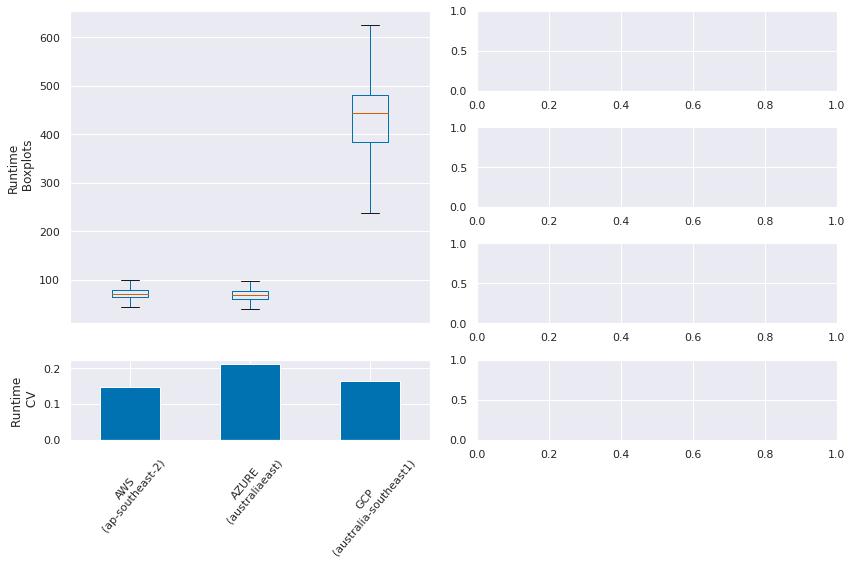

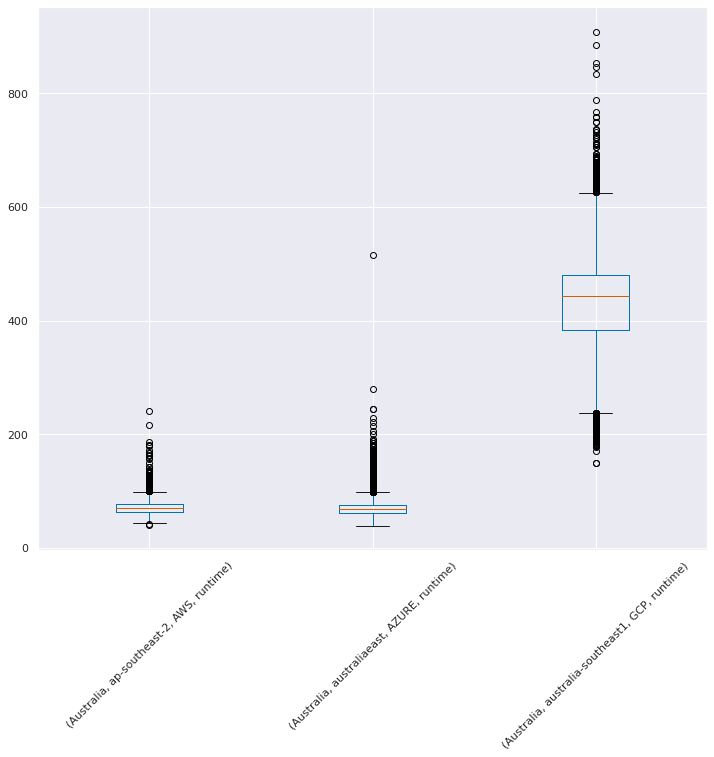

Canada


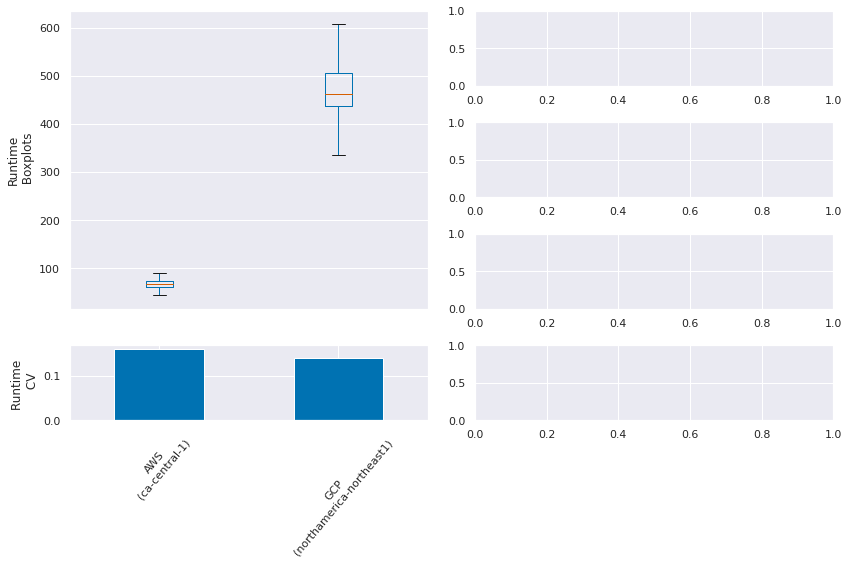

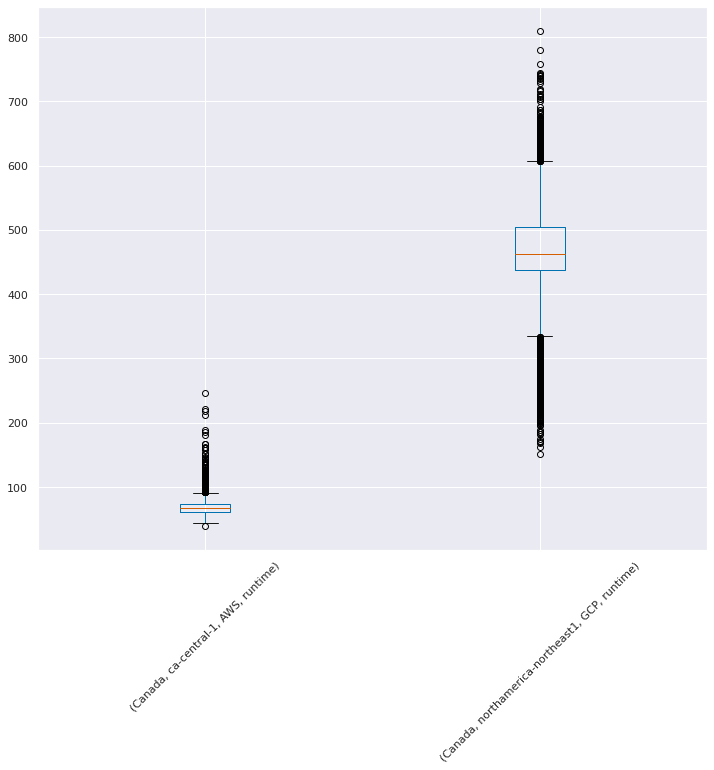

East US


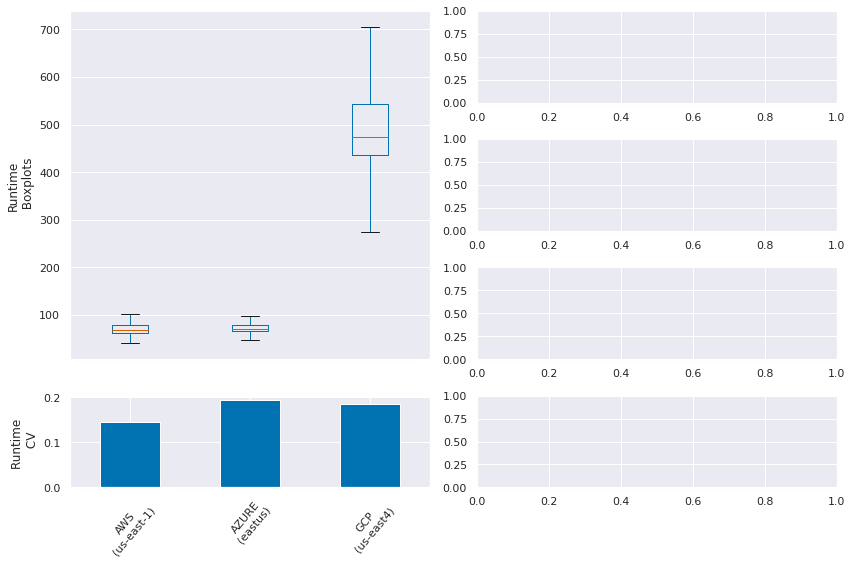

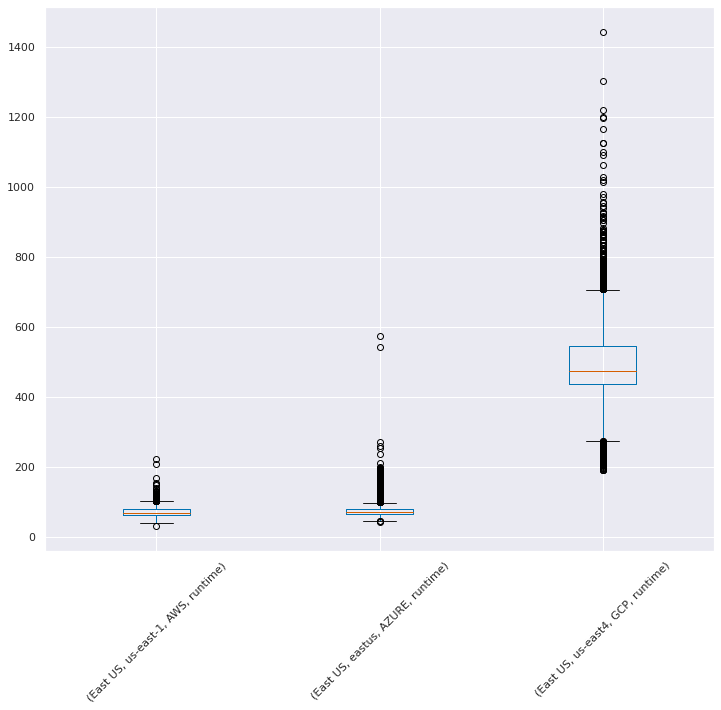

Germany


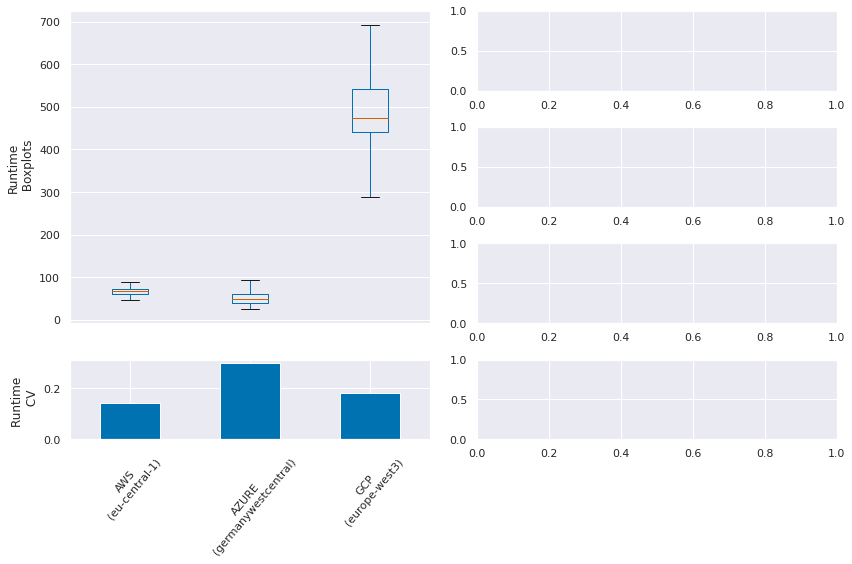

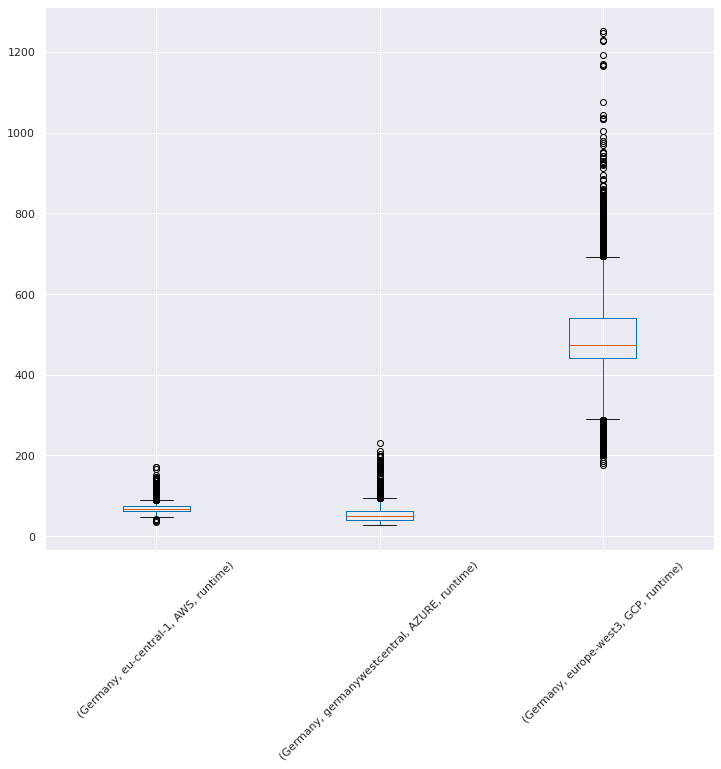

India


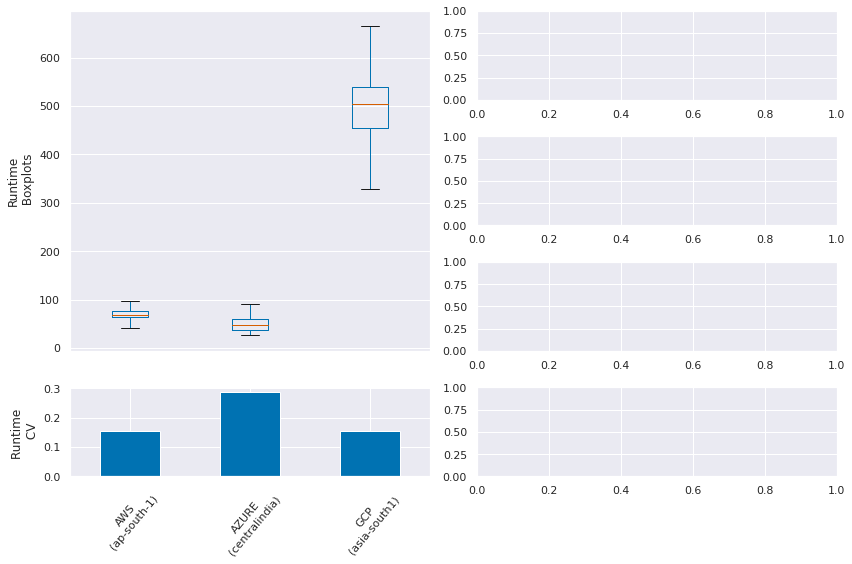

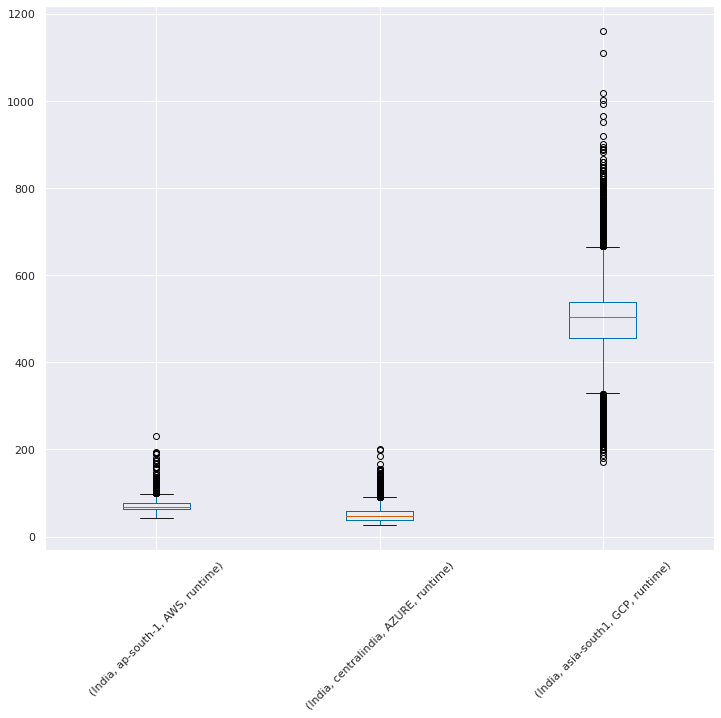

Japan


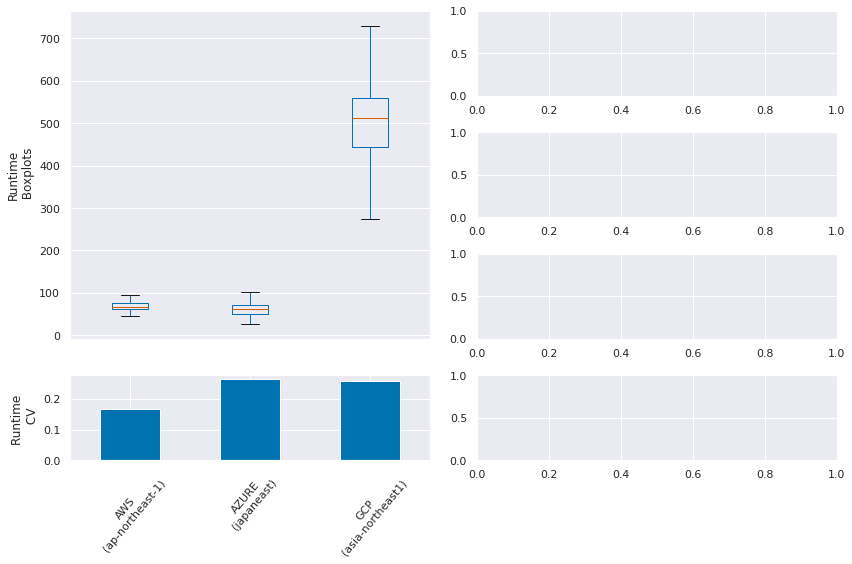

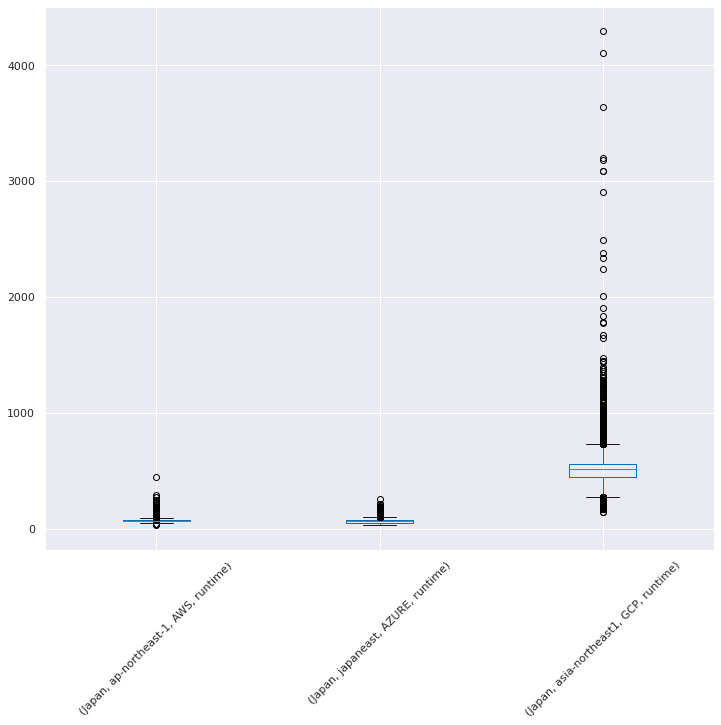

South America


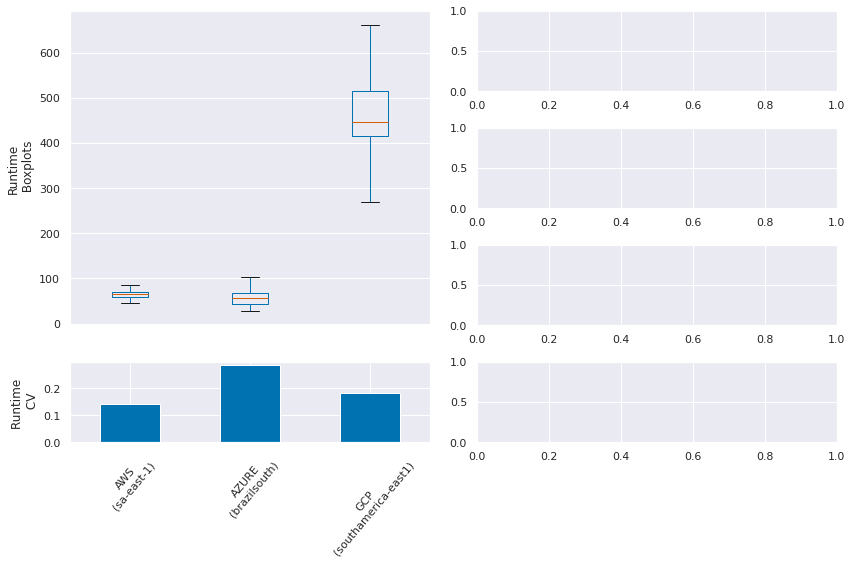

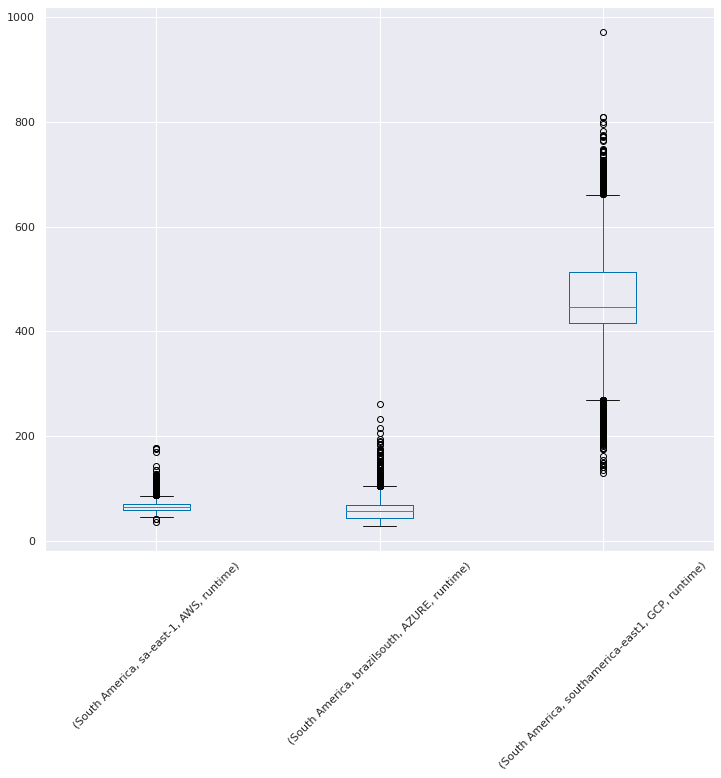

United Kingdom


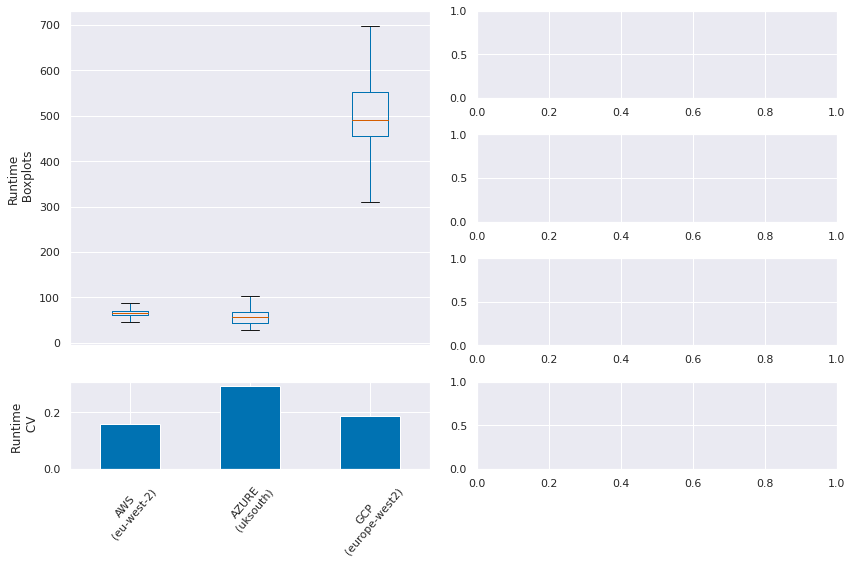

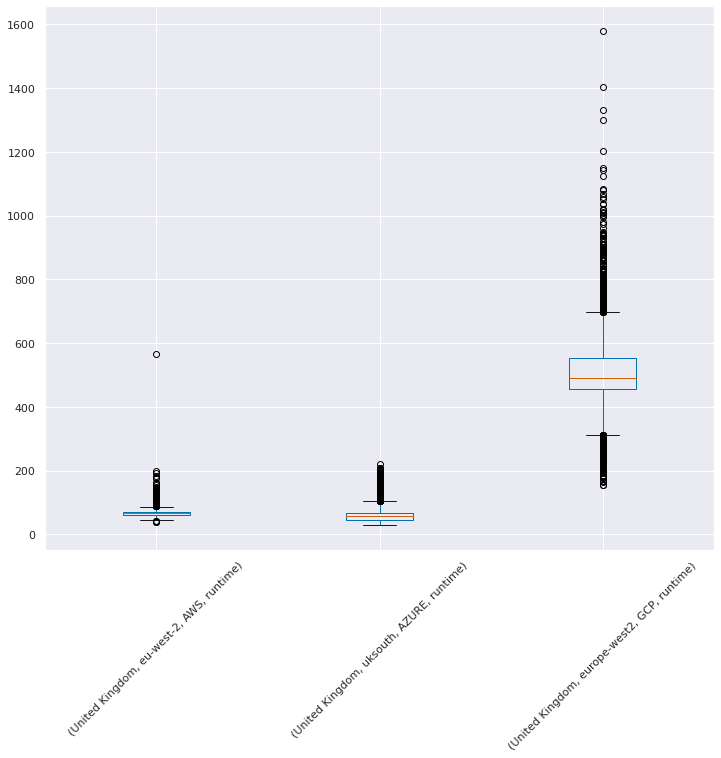

West US


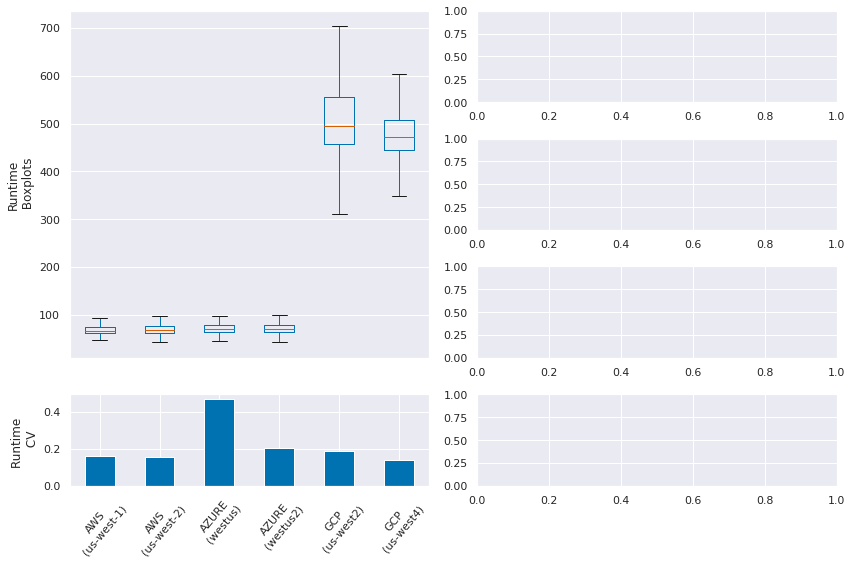

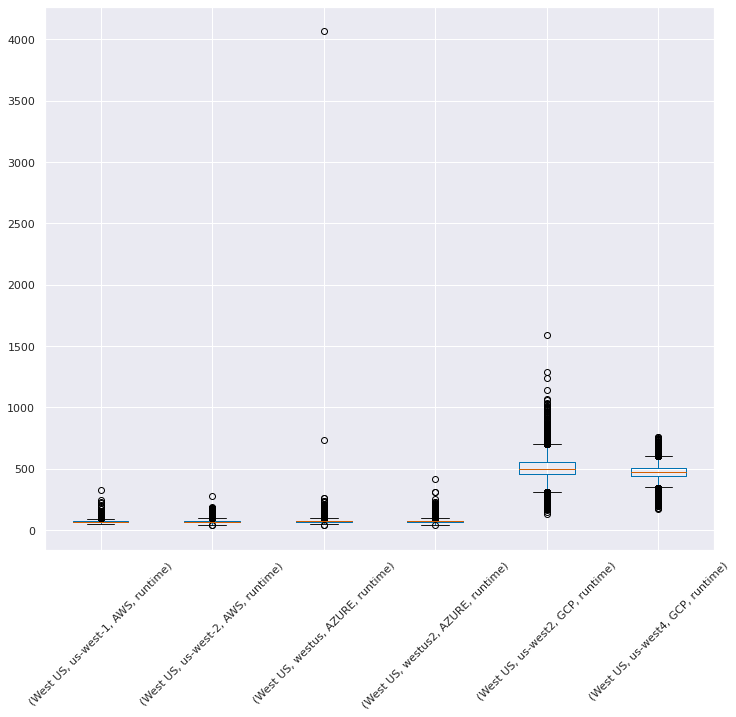

In [33]:
dataset = dataset.sort_values(by=['measure group', 'provider', 'region'])

for measure_group in cov_regional_df.index.get_level_values('measure group').unique():
  fig, axes = plt.subplots(figsize=(12,8), nrows=4, ncols=2, frameon=False)

  gs = axes[0, 0].get_gridspec()
  axes[0, 0].remove()
  axes[1, 0].remove()
  axes[2, 0].remove()
  axbig = fig.add_subplot(gs[:3, 0])

  cov_regional_df[cov_regional_df.index.isin([measure_group], level='measure group')].plot(kind='bar', ax=axes[3, 0])
  dataset[['measure group', 'provider', 'region', 'runtime']][dataset['measure group'] == measure_group].groupby(['measure group', 'region', 'provider'], observed=True).boxplot(subplots=False, ax=axbig, showfliers=False)

  axbig.get_xaxis().set_ticks([])

  axbig.set_ylabel('Runtime\n Boxplots')

  # Set Region Names
  labels = []
  for tick in axes[3, 0].get_xticklabels():
    mapping = provider_region_mapping[tick.get_text()]
    labels.append(f"{mapping['provider']}\n({mapping['region']})")

  axes[3, 0].get_legend().remove()
  axes[3, 0].set_ylabel('Runtime \n CV')
  axes[3, 0].set_xticklabels(labels)
  axes[3, 0].set_xlabel('')
  for tick in axes[3, 0].get_xticklabels():
    tick.set_rotation(50)

  fig.tight_layout()

  print(measure_group)
  plt.savefig(f'cov_regional_cov_boxplot_{measure_group}.pdf')
  plt.show()
  plt.close()

  # # Generate a control figure - to check if correct
  fig, axes = plt.subplots(figsize=(12,10))
  dataset[['measure group', 'provider', 'region', 'runtime']][dataset['measure group'] == measure_group].groupby(['measure group', 'region', 'provider'], observed=True).boxplot(subplots=False, ax=axes, rot=45)
  plt.savefig(f'cov_regional_cov_boxplot_{measure_group}_control.pdf')
  plt.show()
  plt.close()

# Other Stuff (Experimental)

In [34]:
dataset

driver_invocation     workload_invocation provider  \
12     2021-08-01 13:30:03.035 2021-08-01 13:31:08.588      AWS   
13     2021-08-01 13:30:03.035 2021-08-01 13:31:08.588      AWS   
14     2021-08-01 13:30:03.035 2021-08-01 13:31:08.588      AWS   
15     2021-08-01 13:30:03.035 2021-08-01 13:31:08.588      AWS   
16     2021-08-01 13:30:03.035 2021-08-01 13:31:08.588      AWS   
...                        ...                     ...      ...   
499531 2021-09-30 23:30:03.438 2021-09-30 23:30:22.629      GCP   
499532 2021-09-30 23:30:03.438 2021-09-30 23:30:22.629      GCP   
499533 2021-09-30 23:30:03.438 2021-09-30 23:30:22.629      GCP   
499534 2021-09-30 23:30:03.438 2021-09-30 23:30:22.629      GCP   
499535 2021-09-30 23:30:03.438 2021-09-30 23:30:22.629      GCP   

                region  dirty_measurement  \
12      ap-southeast-2               True   
13      ap-southeast-2               True   
14      ap-southeast-2               True   
15      ap-southeast-2               True   
16      ap-southeast-2               True   
...                ...                ...   
499531        us-west4               True   
499532        us-west4               True   
499533        us-west4               True   
499534        us-west4               True   
499535        us-west4               True   

                                 folder_uuid 1_run_id  2_thread_id  \
12      7fe07576-341e-11ec-be3c-8bf2eba3159e       10            0   
13      7fe07576-341e-11ec-be3c-8bf2eba3159e      106            0   
14      7fe07576-341e-11ec-be3c-8bf2eba3159e       67            3   
15      7fe07576-341e-11ec-be3c-8bf2eba3159e       74            3   
16      7fe07576-341e-11ec-be3c-8bf2eba3159e      135            3   
...                                      ...      ...          ...   
499531  c0093932-341b-11ec-be3c-8bf2eba3159e       90            1   
499532  c0093932-341b-11ec-be3c-8bf2eba3159e       83            2   
499533  c0093932-341b-11ec-be3c-8bf2eba3159e       10            2   
499534  c0093932-341b-11ec-be3c-8bf2eba3159e      147            3   
499535  c0093932-341b-11ec-be3c-8bf2eba3159e       35            0   

                SAAFMemoryDeltaError               SAAFMemoryError  ...  \
12                               NaN                           NaN  ...   
13                               NaN                           NaN  ...   
14                               NaN                           NaN  ...   
15                               NaN                           NaN  ...   
16                               NaN                           NaN  ...   
...                              ...                           ...  ...   
499531  /proc/vmstat does not exist!  /proc/vmstat does not exist!  ...   
499532  /proc/vmstat does not exist!  /proc/vmstat does not exist!  ...   
499533  /proc/vmstat does not exist!  /proc/vmstat does not exist!  ...   
499534  /proc/vmstat does not exist!  /proc/vmstat does not exist!  ...   
499535  /proc/vmstat does not exist!  /proc/vmstat does not exist!  ...   

        functionMemory  pageFaults  pageFaultsDelta    vmID   dow_utc  \
12                1024      137583             3843  trBPwA    Sunday   
13                1024      637963             3834  7VQRrj    Sunday   
14                1024      422042             3842  KKdsYx    Sunday   
15                1024      457005             3852  trBPwA    Sunday   
16                1024      774974             3854  trBPwA    Sunday   
...                ...         ...              ...     ...       ...   
499531            <NA>        <NA>             <NA>    <NA>  Thursday   
499532            <NA>        <NA>             <NA>    <NA>  Thursday   
499533            <NA>        <NA>             <NA>    <NA>  Thursday   
499534            <NA>        <NA>             <NA>    <NA>  Thursday   
499535            <NA>        <NA>             <NA>    <NA>  Thursday   

        tod_utc             timezone  measure gr

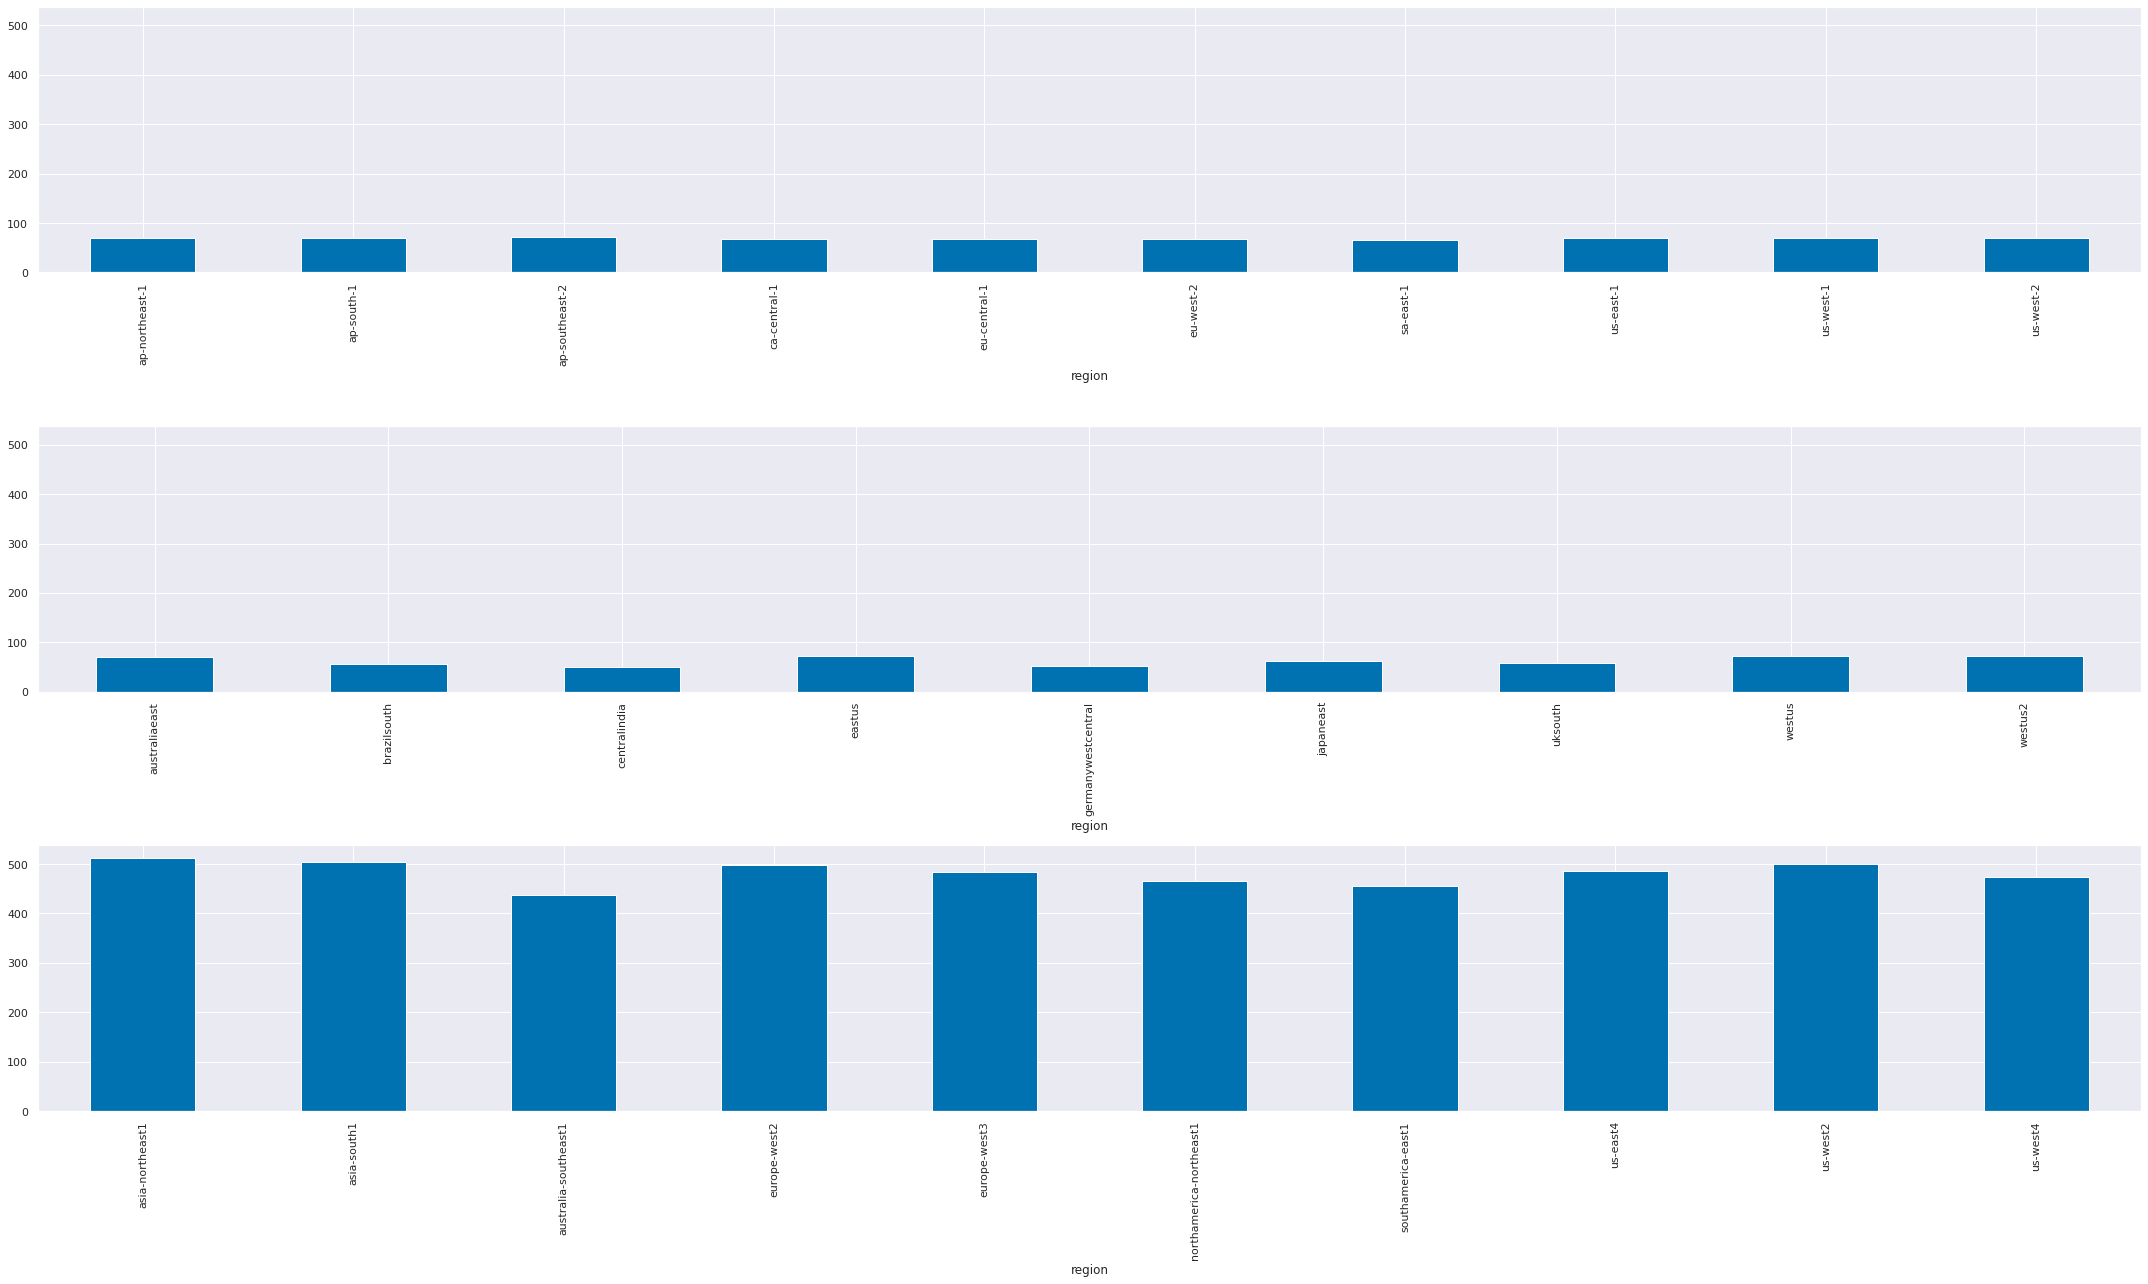

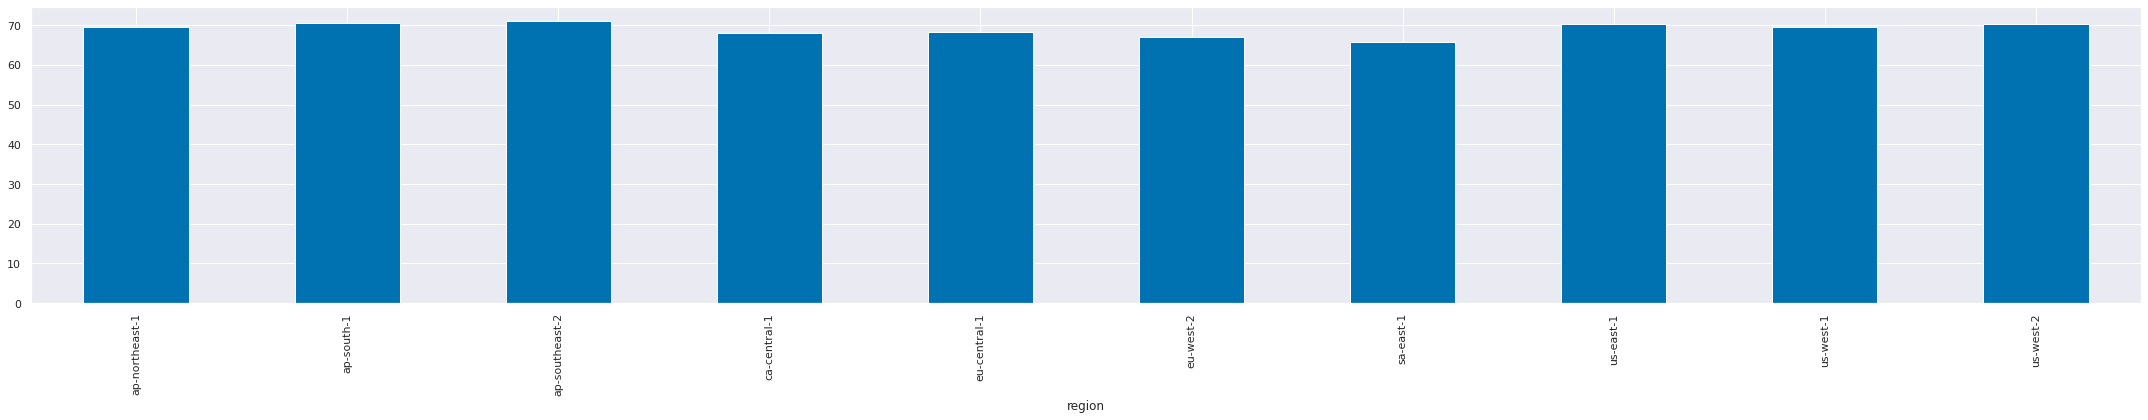

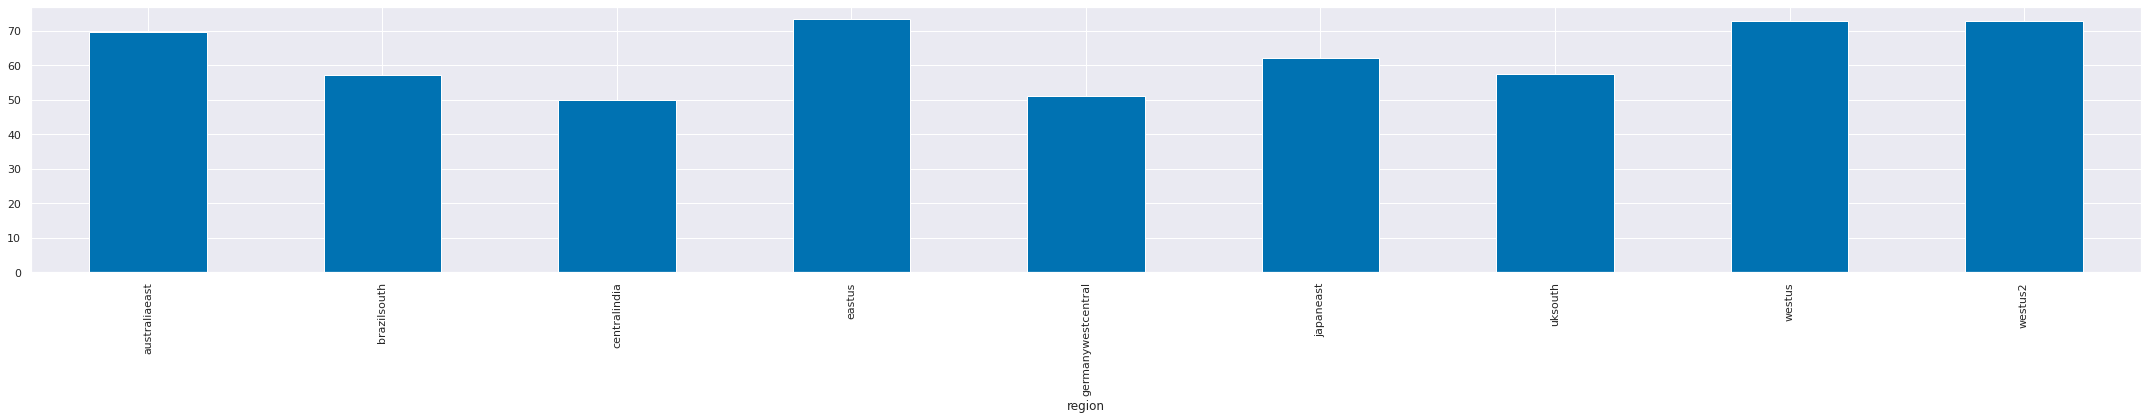

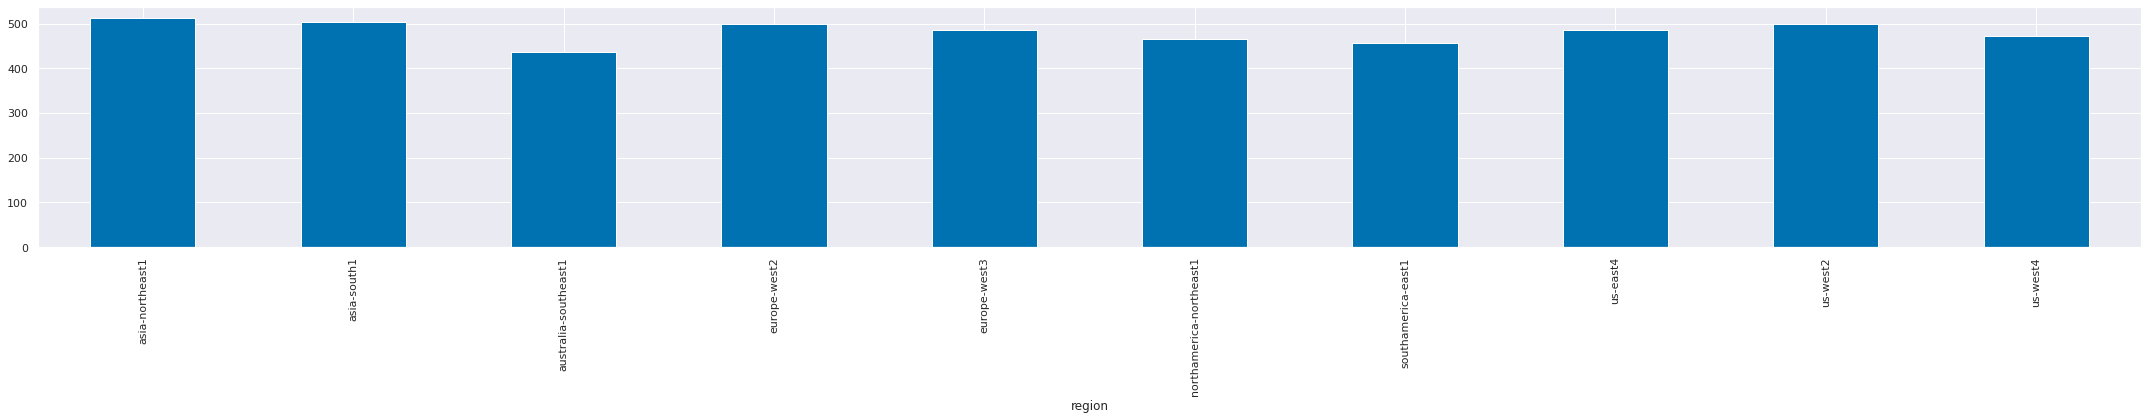

In [35]:
fig, axes = plt.subplots(figsize=(30,18), nrows=3, ncols=1, sharey='all')
dataset[dataset['provider'] == 'AWS'].sort_values(['measure group']).groupby( ['region'])['runtime'].mean().dropna().plot(kind='bar', by='region', ax=axes[0])
dataset[dataset['provider'] == 'AZURE'].sort_values(['measure group']).groupby( ['region'])['runtime'].mean().dropna().plot(kind='bar', by='region', ax=axes[1])
dataset[dataset['provider'] == 'GCP'].sort_values(['measure group']).groupby( ['region'])['runtime'].mean().dropna().plot(kind='bar', by='region', ax=axes[2])

fig.tight_layout()
plt.show()
plt.close()

fig, axes = plt.subplots(figsize=(30,6))
dataset[dataset['provider'] == 'AWS'].sort_values(['measure group']).groupby( ['region'])['runtime'].mean().dropna().plot(kind='bar', by='region', ax=axes)
fig.tight_layout()
plt.show()
plt.close()

fig, axes = plt.subplots(figsize=(30,6))
dataset[dataset['provider'] == 'AZURE'].sort_values(['measure group']).groupby( ['region'])['runtime'].mean().dropna().plot(kind='bar', by='region', ax=axes)
fig.tight_layout()
plt.show()
plt.close()

fig, axes = plt.subplots(figsize=(30,6))
dataset[dataset['provider'] == 'GCP'].sort_values(['measure group']).groupby( ['region'])['runtime'].mean().dropna().plot(kind='bar', by='region', ax=axes)
fig.tight_layout()
plt.show()
plt.close()

In [36]:
provider_regions_df = dataset[['provider', 'region']].value_counts().reset_index(name='count')

In [37]:
def plot_mean_col(dataset, provider, region, col):
    provider_df = dataset[dataset['provider'] == provider]
    provider_region_df = provider_df[provider_df['region'] == region]
    mean_latency_df = provider_region_df.groupby(['driver_invocation'])[col].mean()
    
    fig, ax = plt.subplots(figsize=(220,6))
    mean_latency_df.plot(title=f'{provider} {region} mean {col}', style='.-')

    hours = mdates.MinuteLocator(byminute=[0,30]) #or use interval

    hours.MAXTICKS = 3392

    h_fmt = mdates.DateFormatter('%a %H')


    ax.xaxis.set_major_locator(hours)
    ax.xaxis.set_major_formatter(h_fmt)

    fig.autofmt_xdate()

    plt.xticks(rotation=90)
    plt.savefig(f'plot_mean_col_long_{provider}_{region}_{col}.pdf')
    plt.show()
    plt.close()

In [38]:
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import multiprocessing

def plot(indexrowpair):
    index = indexrowpair[0]
    row = indexrowpair[1]
    provider = row['provider']
    region =  row['region']
    df = dataset[['provider', 'region', 'latency', 'runtime', 'driver_invocation']] #.copy()
    plot_mean_col(df, provider, region, 'latency')
    plot_mean_col(df, provider, region, 'runtime')
    
   
# with ThreadPoolExecutor(max_workers=32) as executor:
#    result = executor.map(plot, provider_regions_df.iterrows())
#    print(list(result))

# TODO: not running
# for irp in provider_regions_df.iterrows():
#      plot(irp)

In [39]:
unique_cpu_models = dataset.groupby(['provider'])['cpuModel'].nunique()
# unique_vendors = dataset.groupby(['provider'])['vendorId'].nunique()

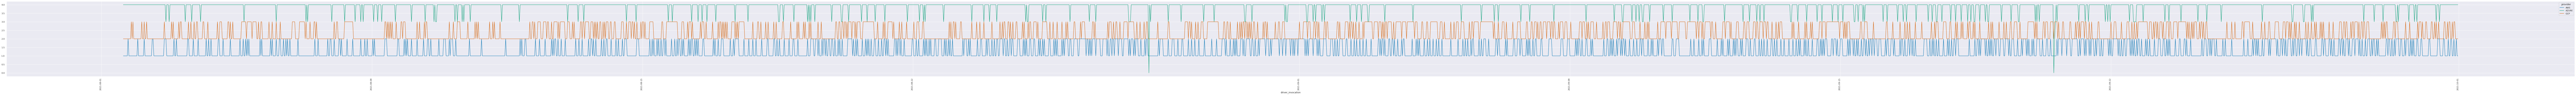

In [40]:
fig, ax = plt.subplots(figsize=(240,8))
dataset.groupby(['driver_invocation', 'provider'])['cpuType'].nunique().unstack().plot(ax=ax, kind='line')

plt.xticks(rotation=90)
plt.show()
plt.close()

In [41]:
region = 'sa-east-1'
provider = 'AWS'

In [42]:
# for mg in measure_groups:
#   for provider in measure_groups[mg]['providers']:
#     regions = measure_groups[mg]['providers'][provider]
#     if len(regions) > 0:
      
#       for region in regions:
#         fig, ax = plt.subplots(figsize=(12,8))
#         df = dataset[ (dataset['region'] == region) & (dataset['provider'] == provider)]
#         df.groupby(['local_dow'])['runtime'].agg(['mean', 'std']).loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']].plot(title=f'{mg} - {provider} Mean with Std, {region}', kind='bar', yerr='std', ax=ax)

#         plt.show()
#         plt.close()

In [43]:
# mgs = measure_groups.keys()
# for mg in mgs:
#   for provider in measure_groups[mg]['providers']:
#     regions = measure_groups[mg]['providers'][provider]
#     if len(regions) > 0:
      
#       for region in regions:
#         fig, ax = plt.subplots(figsize=(24,8))
#         df = dataset[ (dataset['region'] == region) & (dataset['provider'] == provider)]
#         df.groupby(['local_tod'])['runtime'].agg(['mean', 'std']).plot(title=f'{mg} - {provider} Mean with Std, {region}', kind='bar', yerr='std', ax=ax)
#         plt.show()
#         plt.close()

In [44]:
def get_average_responses_per_region_and_local_tod(dataset):
  df = dataset.groupby(['region', 'local_tod'])[ ['driver_invocation'] ].agg(['count', 'nunique'])
  return (df[ ('driver_invocation', 'count') ] / df[ ('driver_invocation', 'nunique') ]).reset_index(name ='Average Responses')
avg_reponses_df = get_average_responses_per_region_and_local_tod(dataset)
avg_reponses_df = avg_reponses_df.set_index('local_tod')

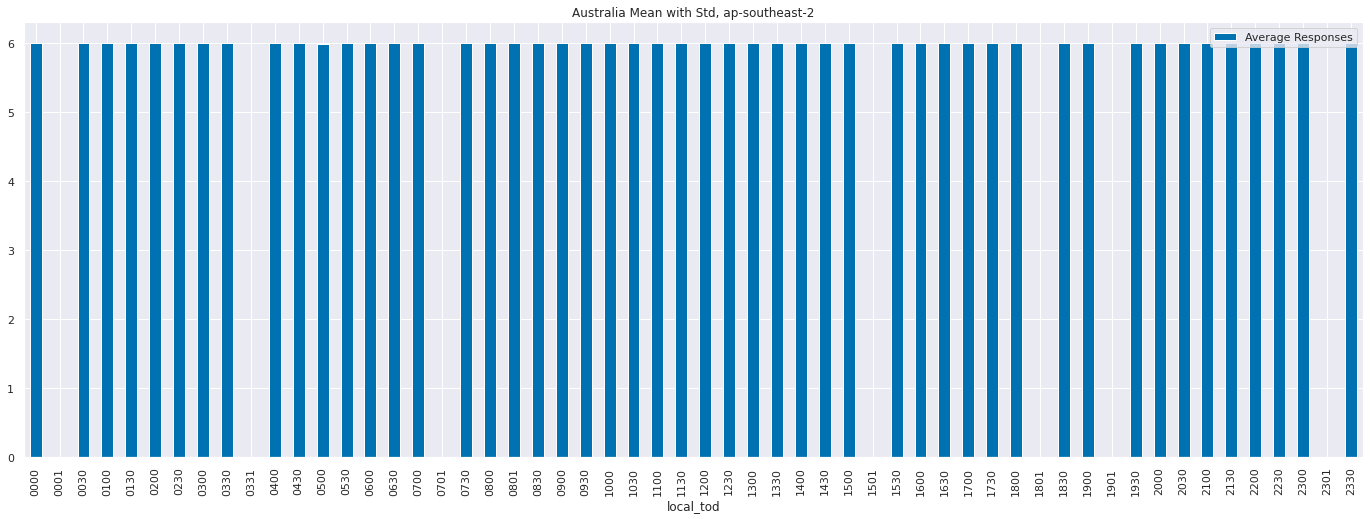

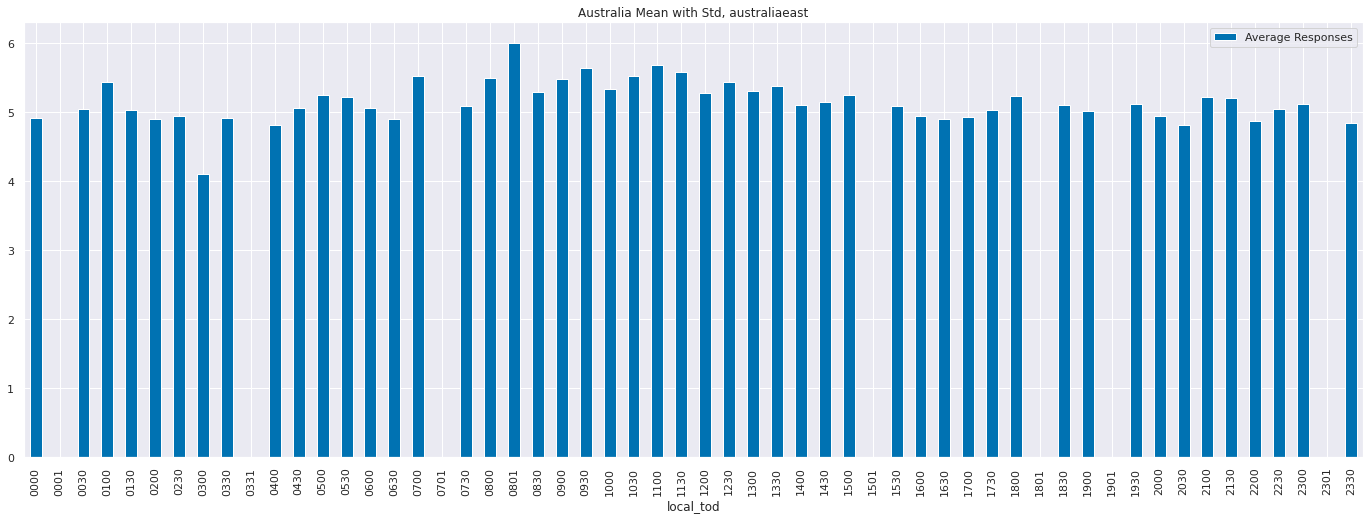

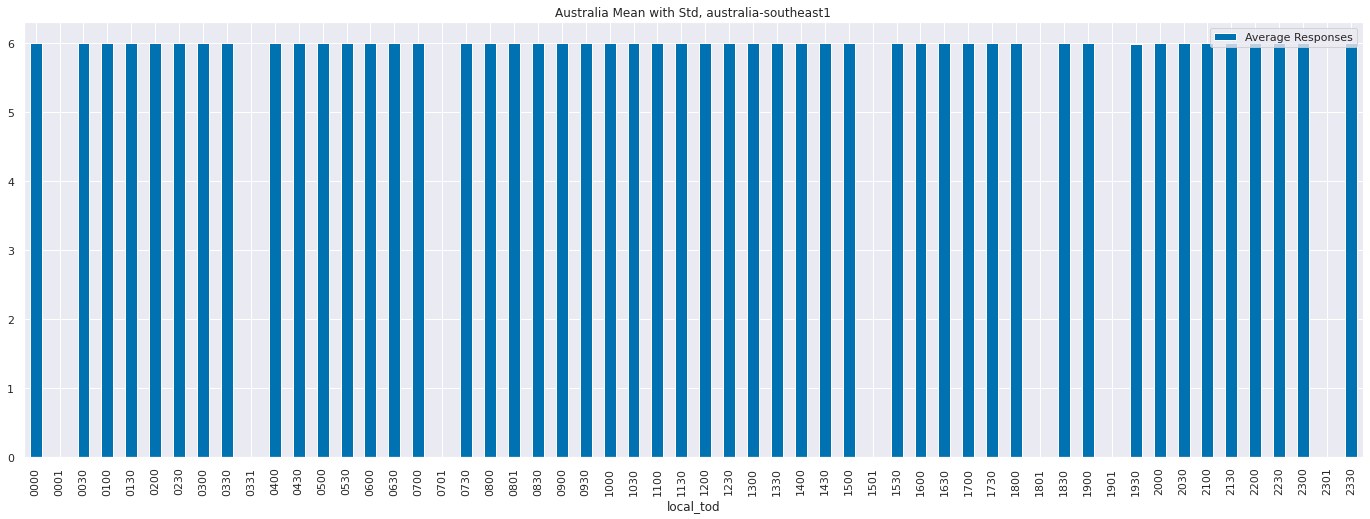

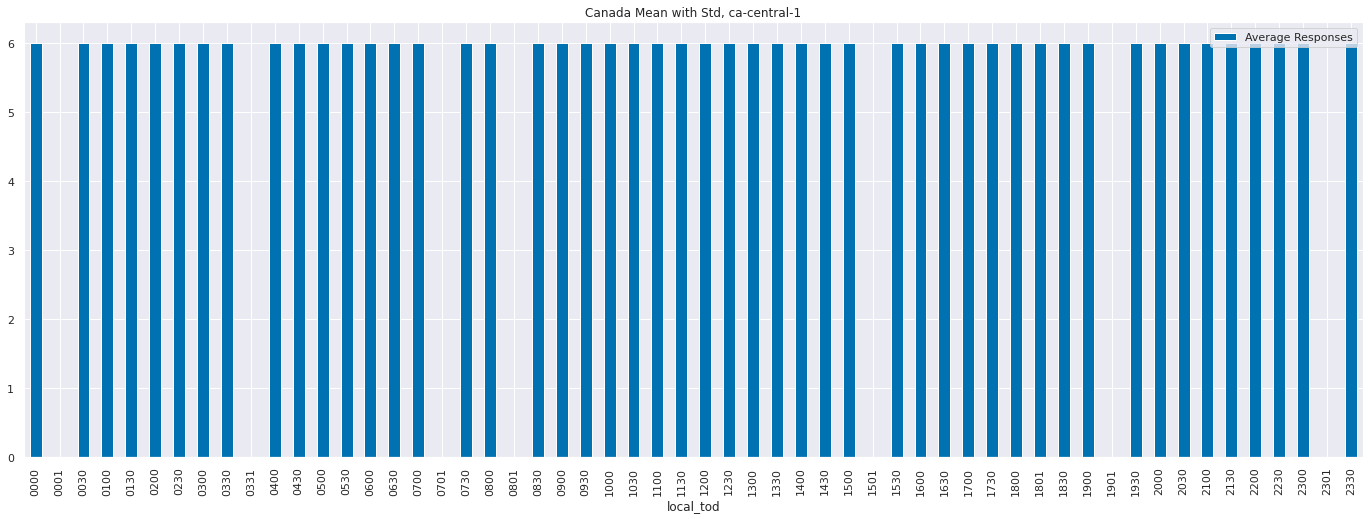

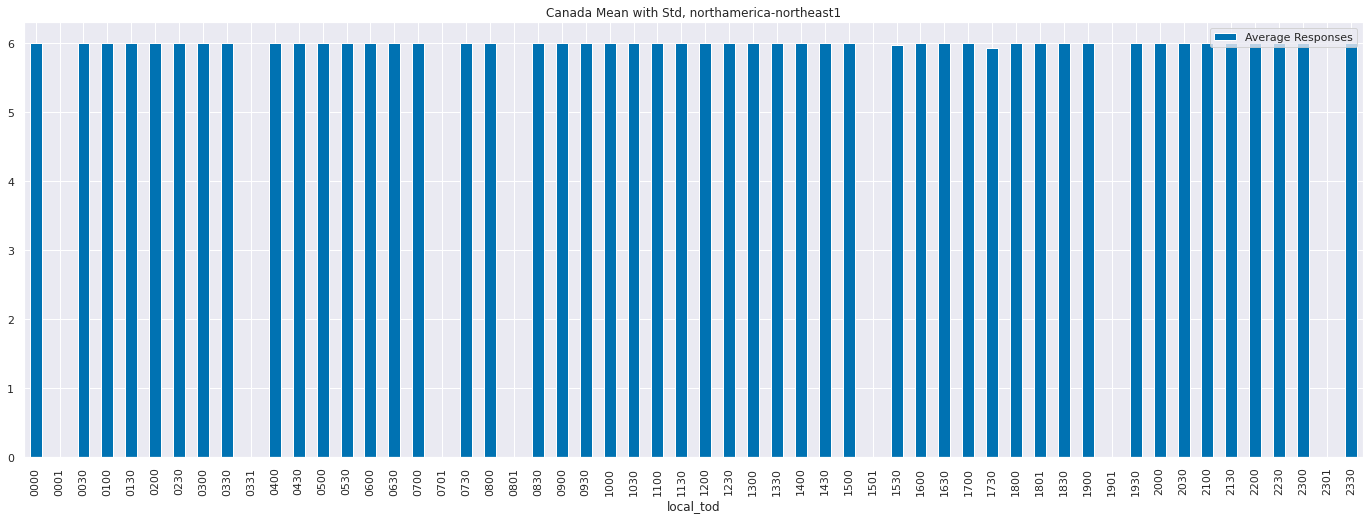

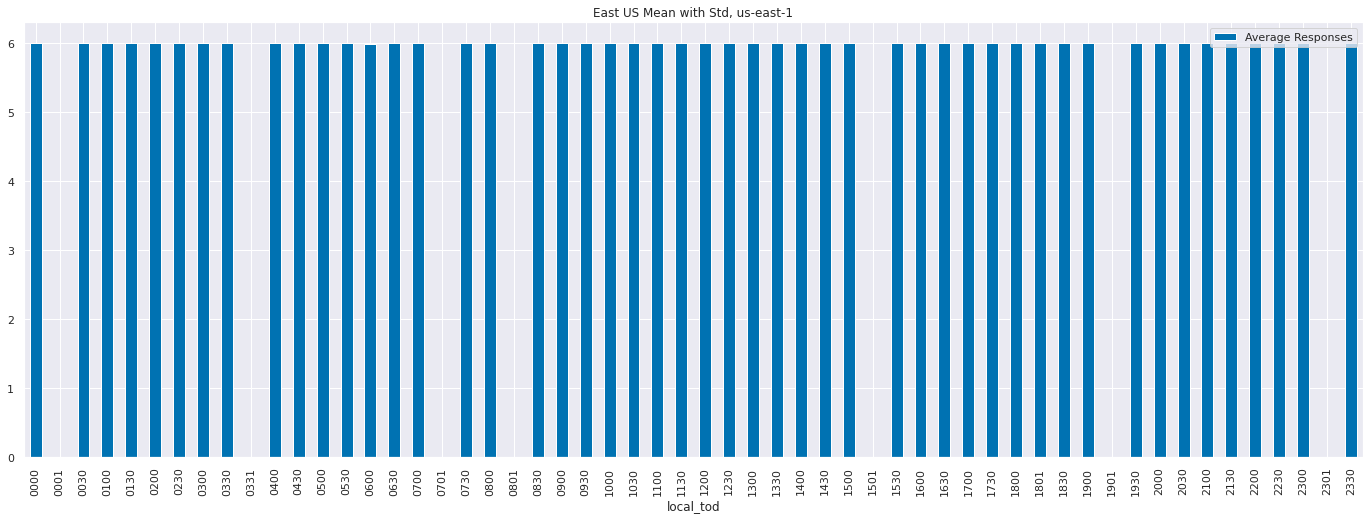

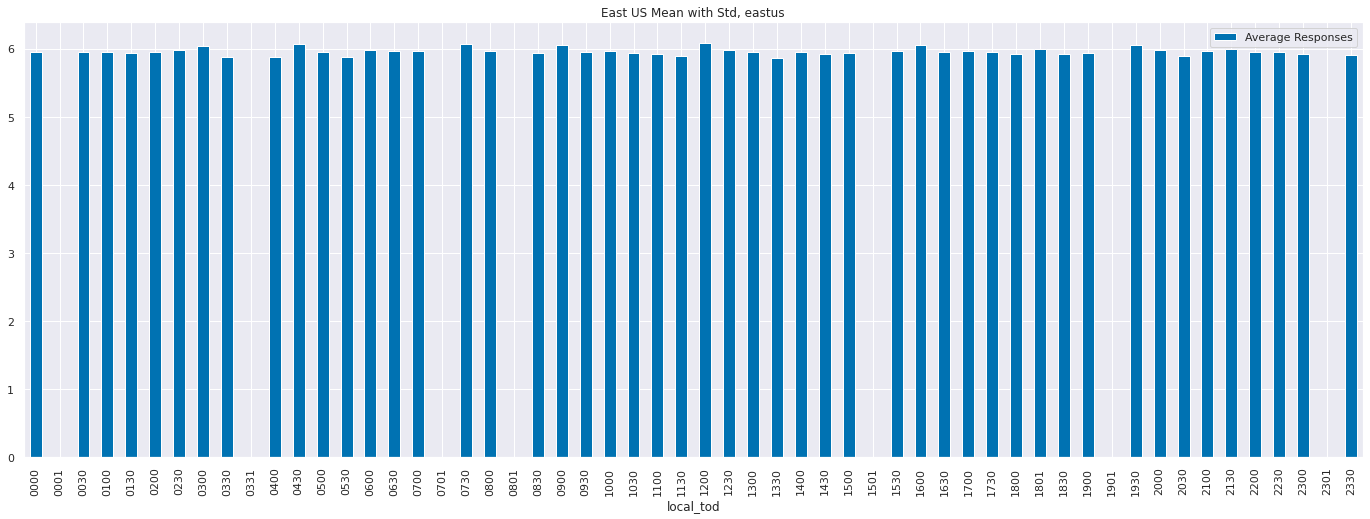

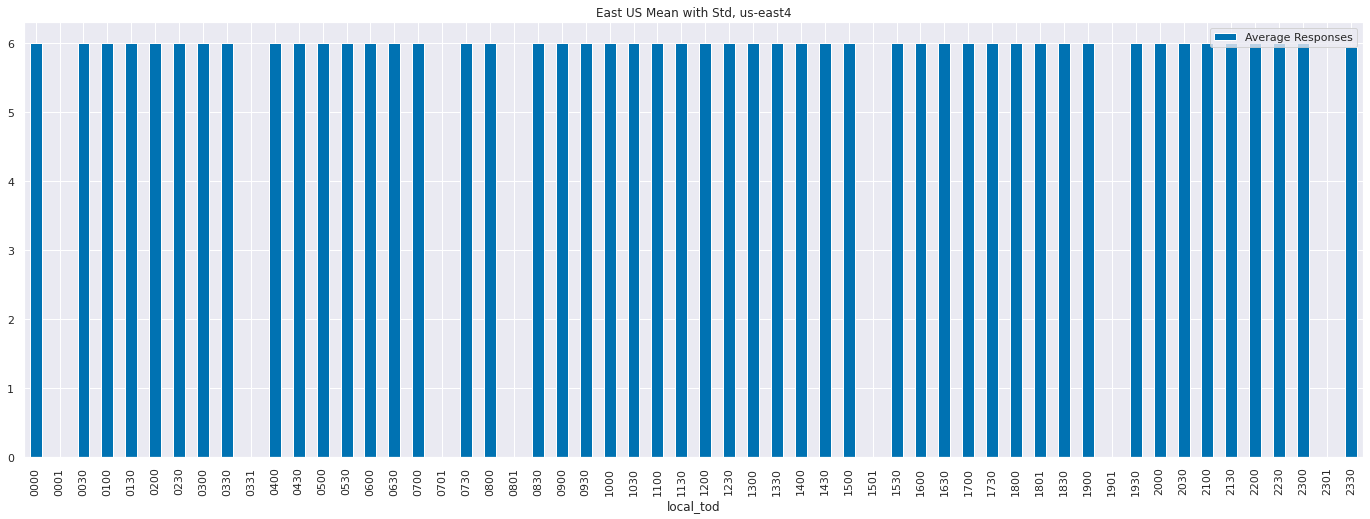

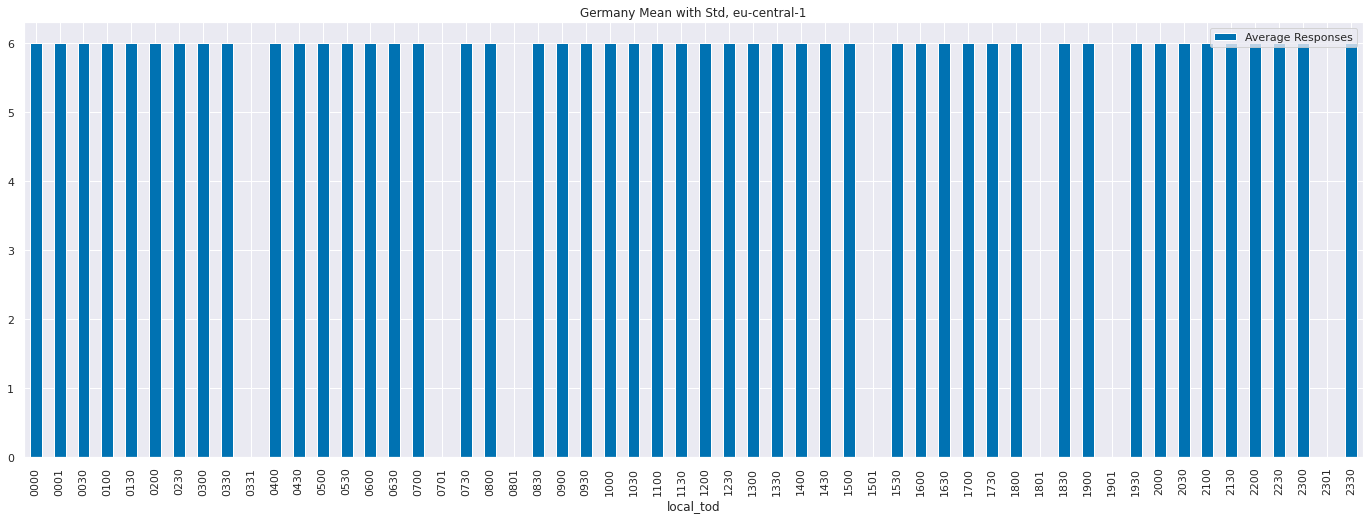

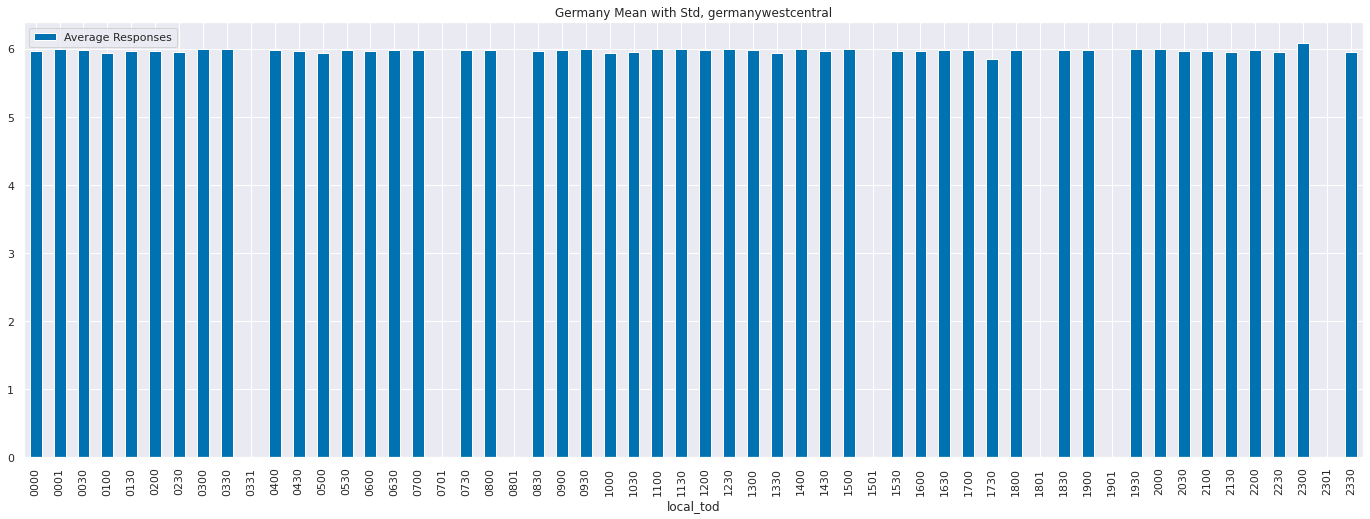

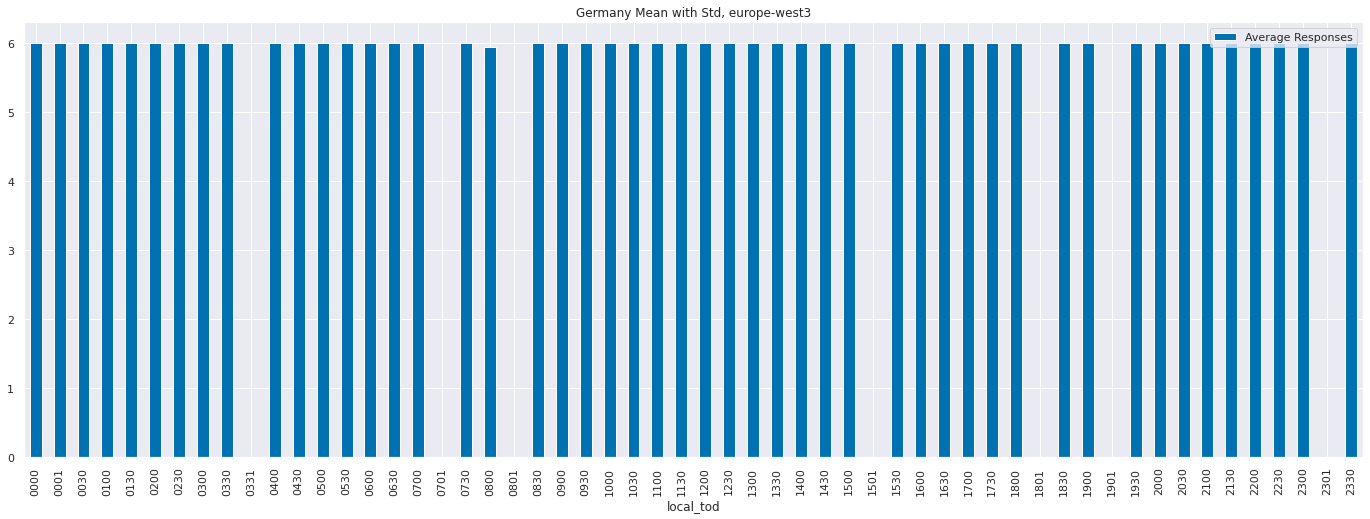

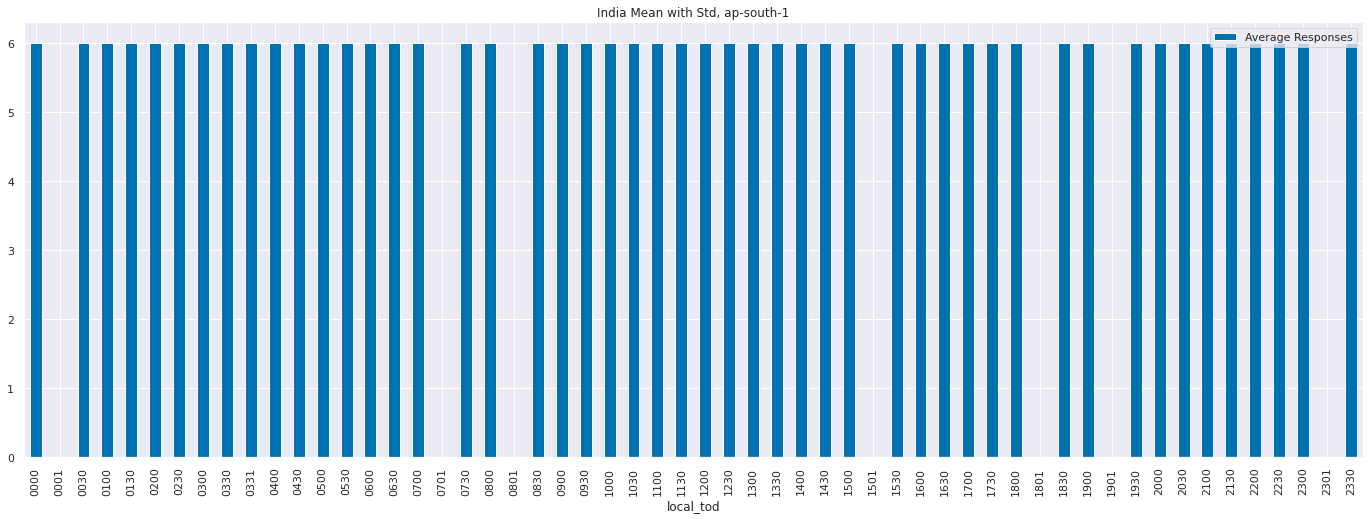

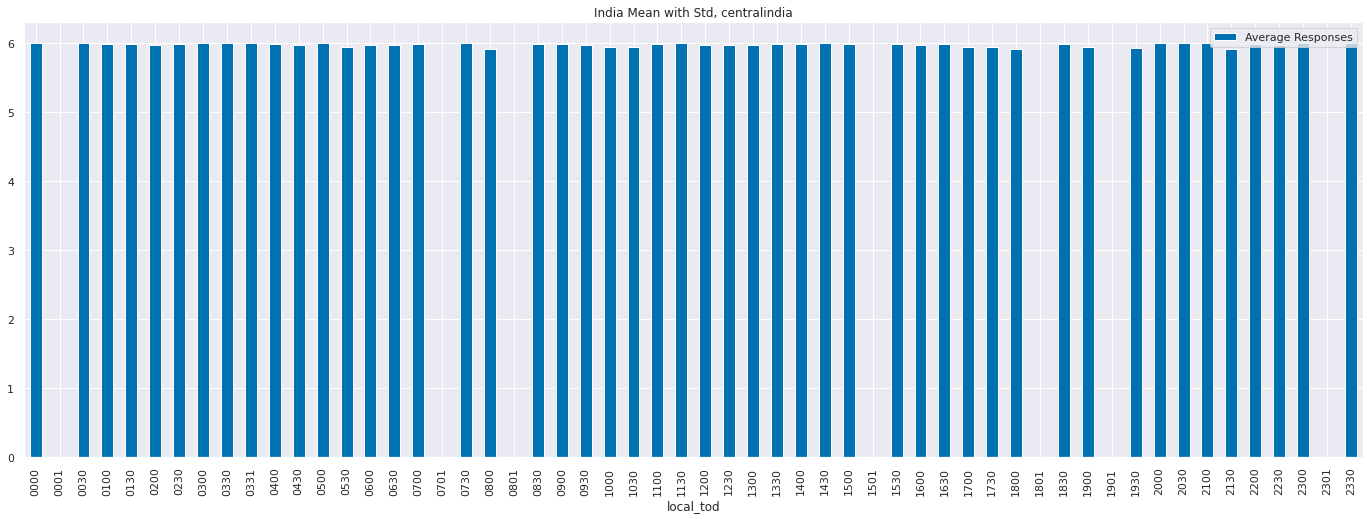

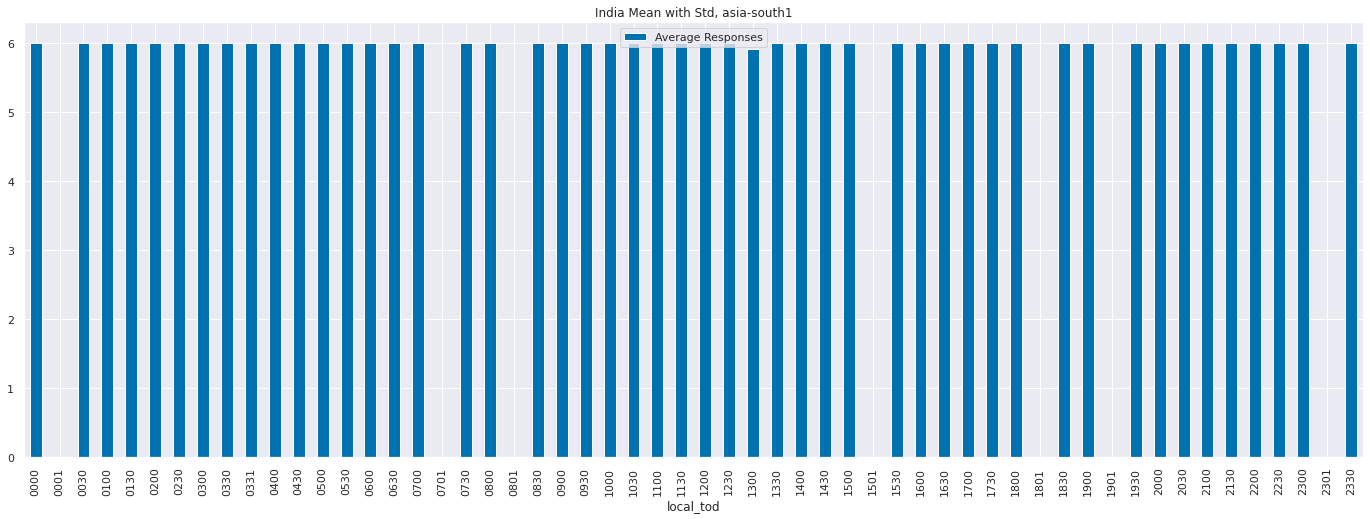

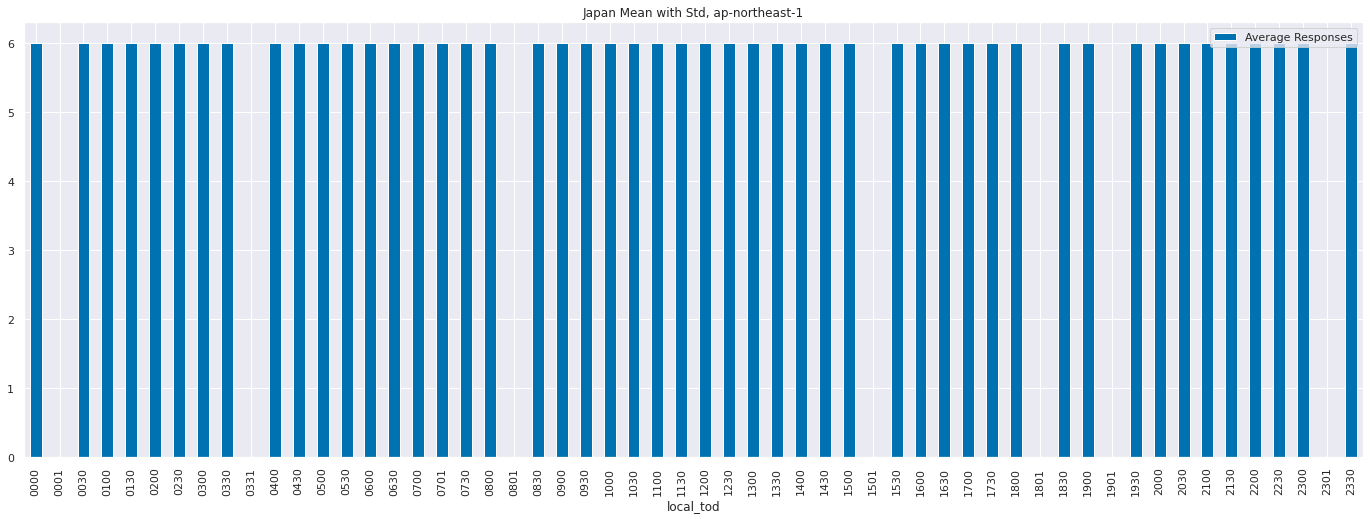

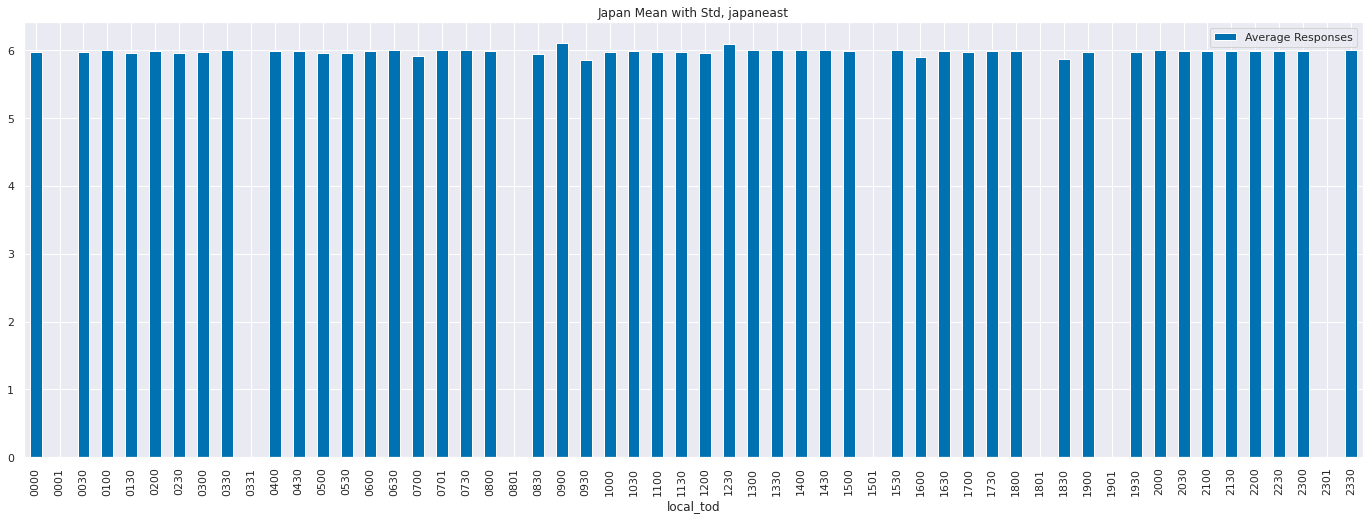

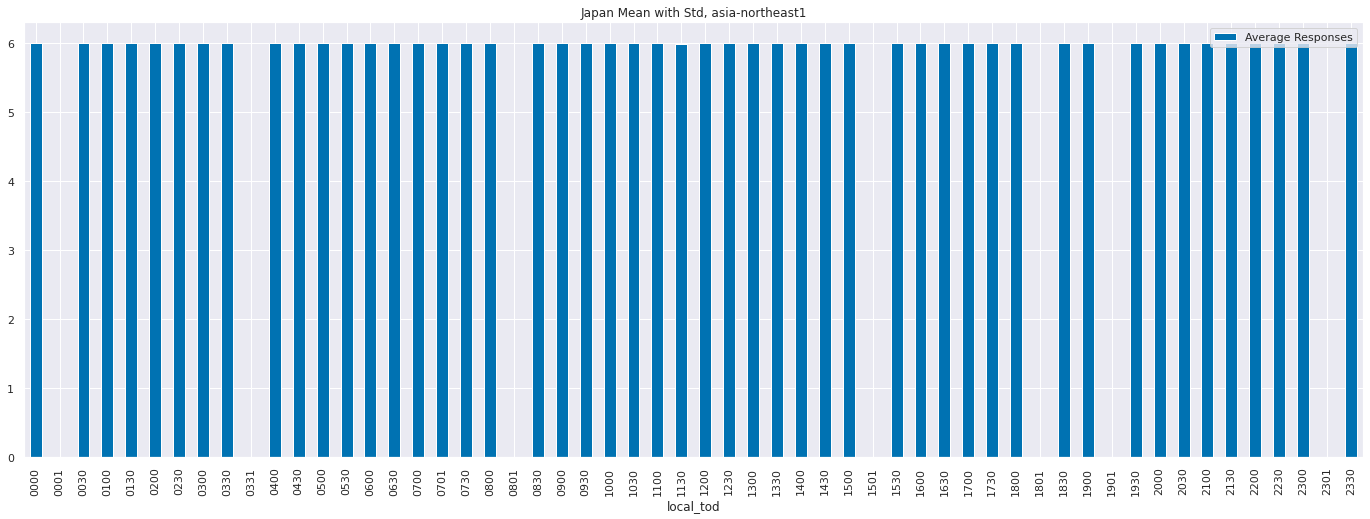

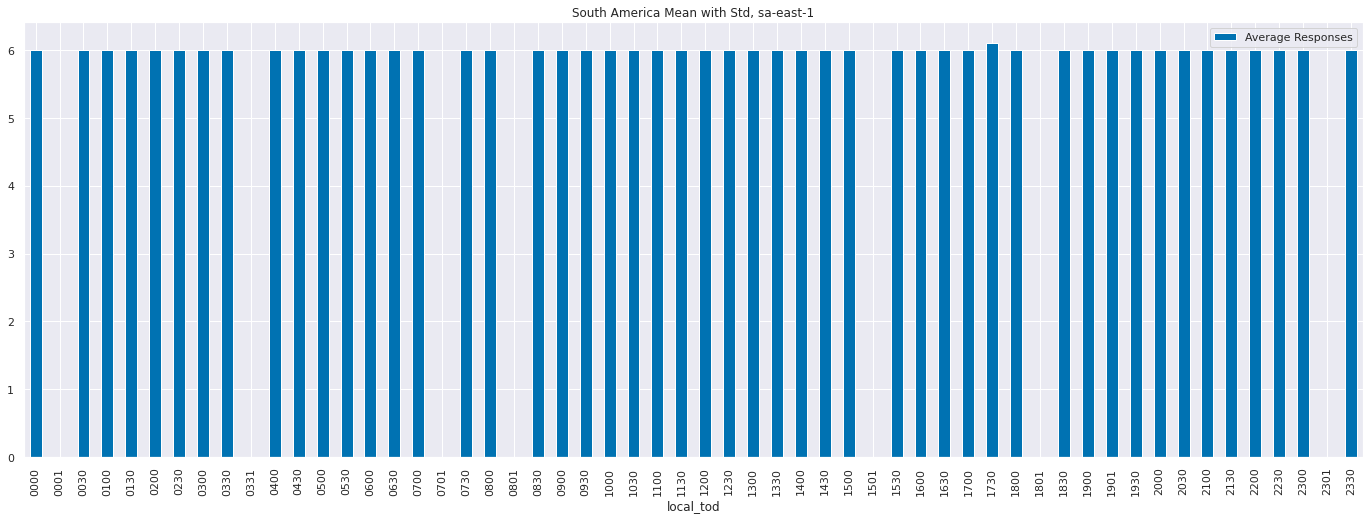

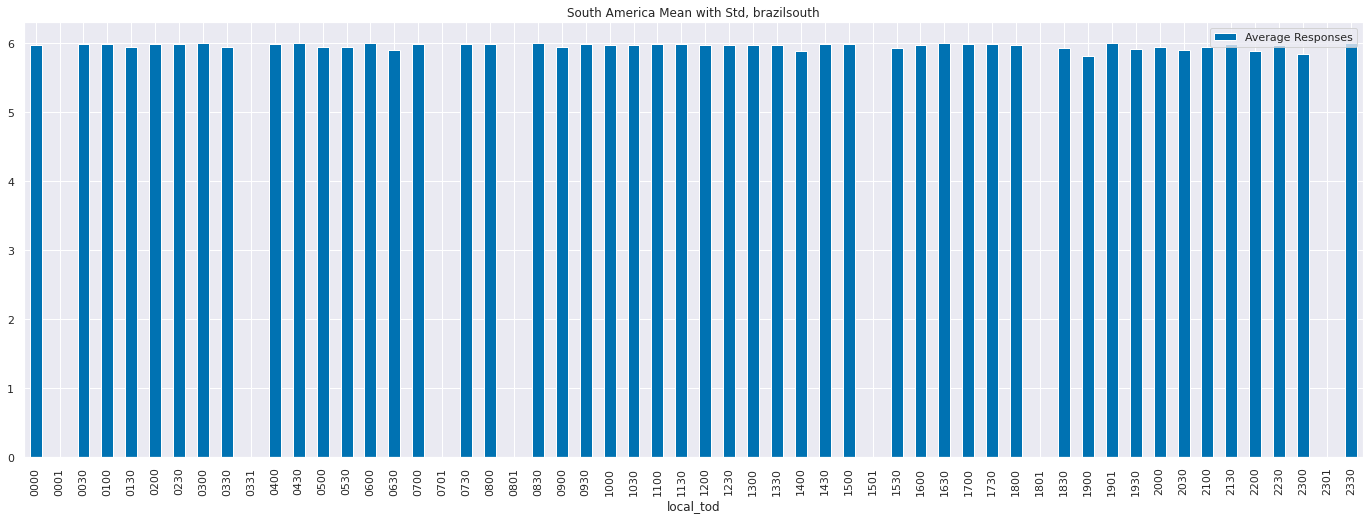

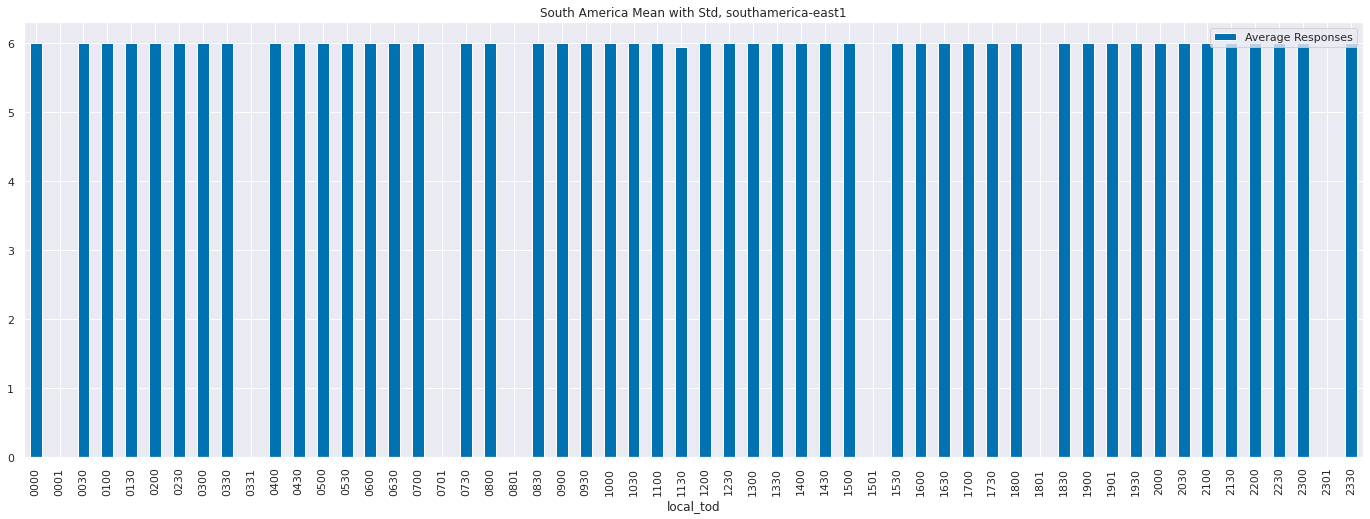

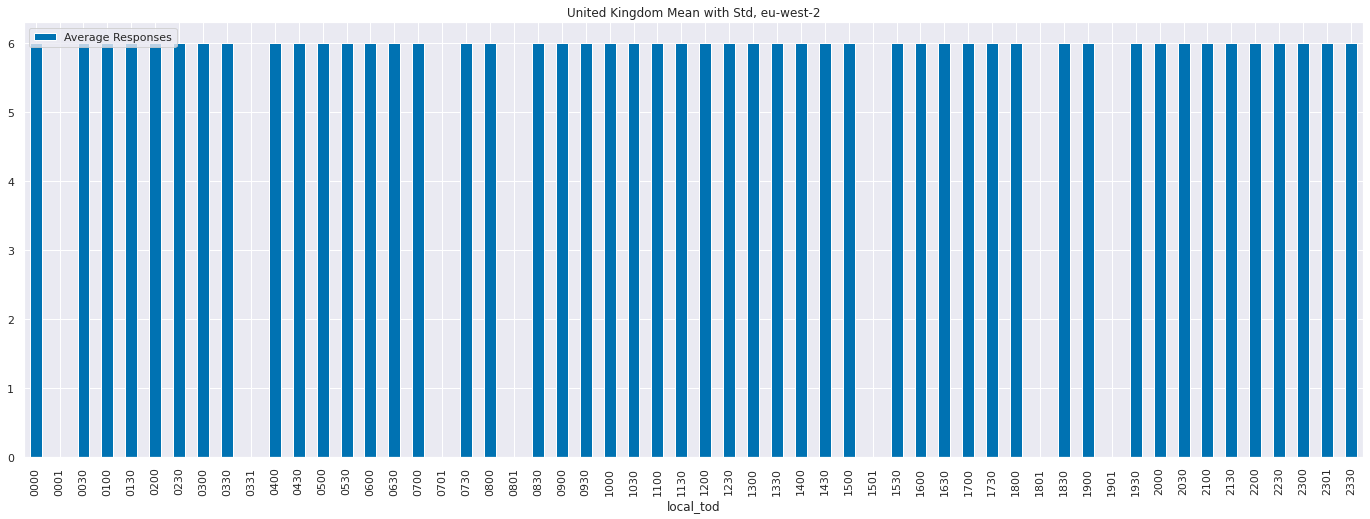

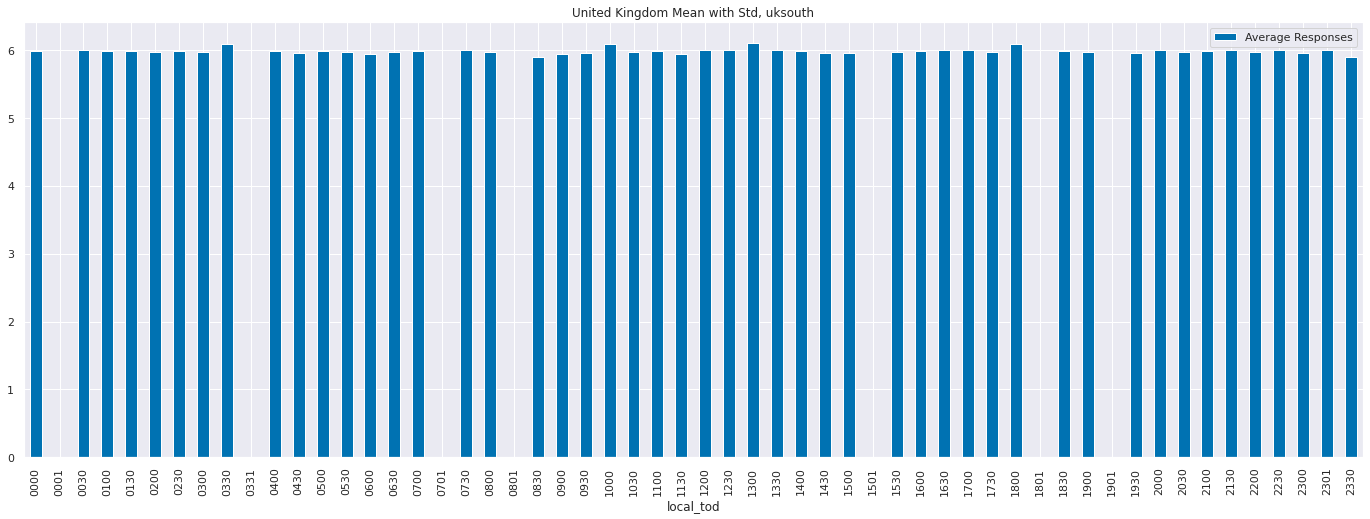

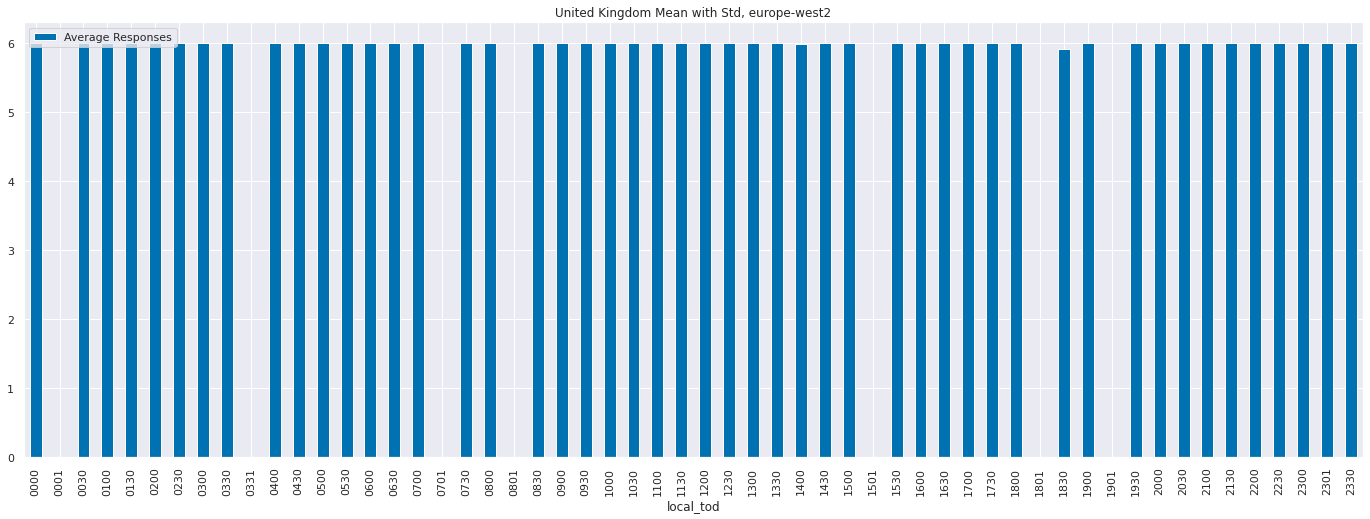

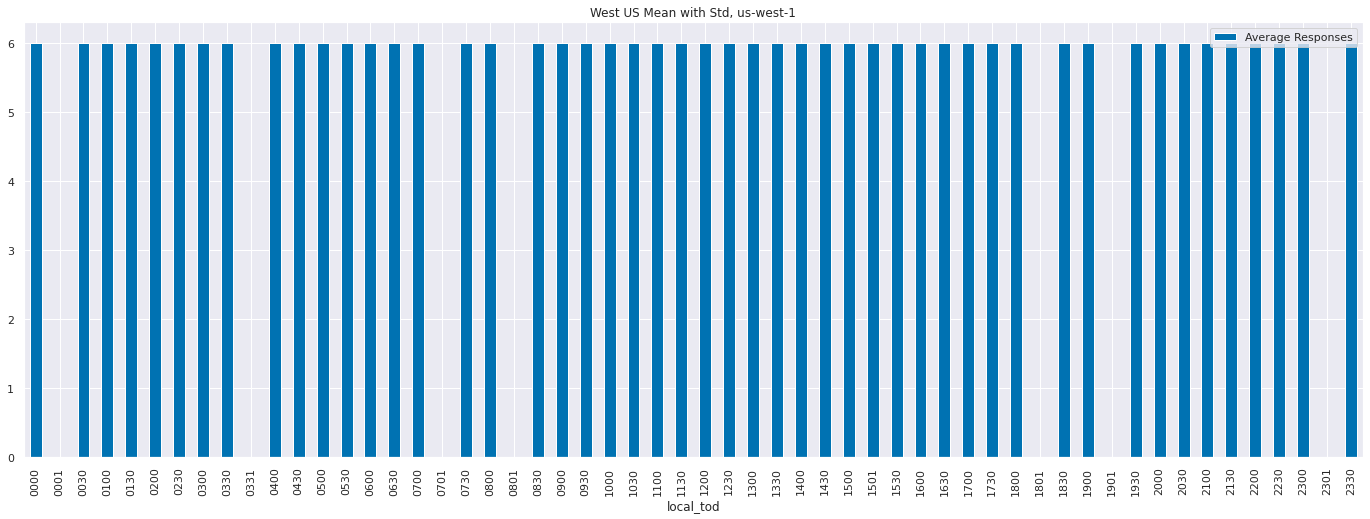

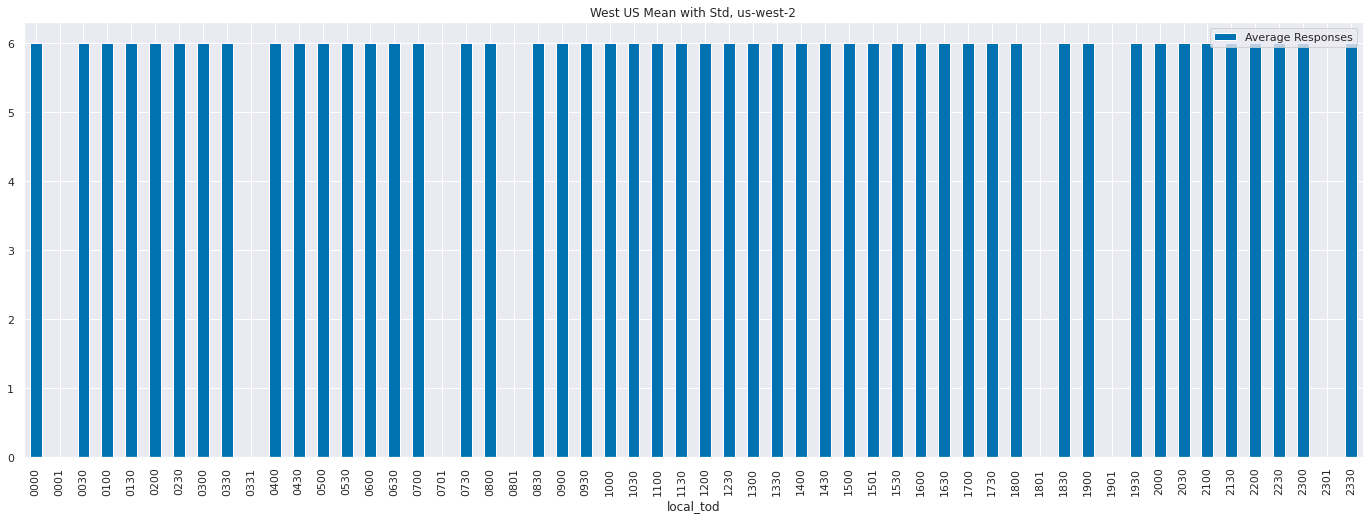

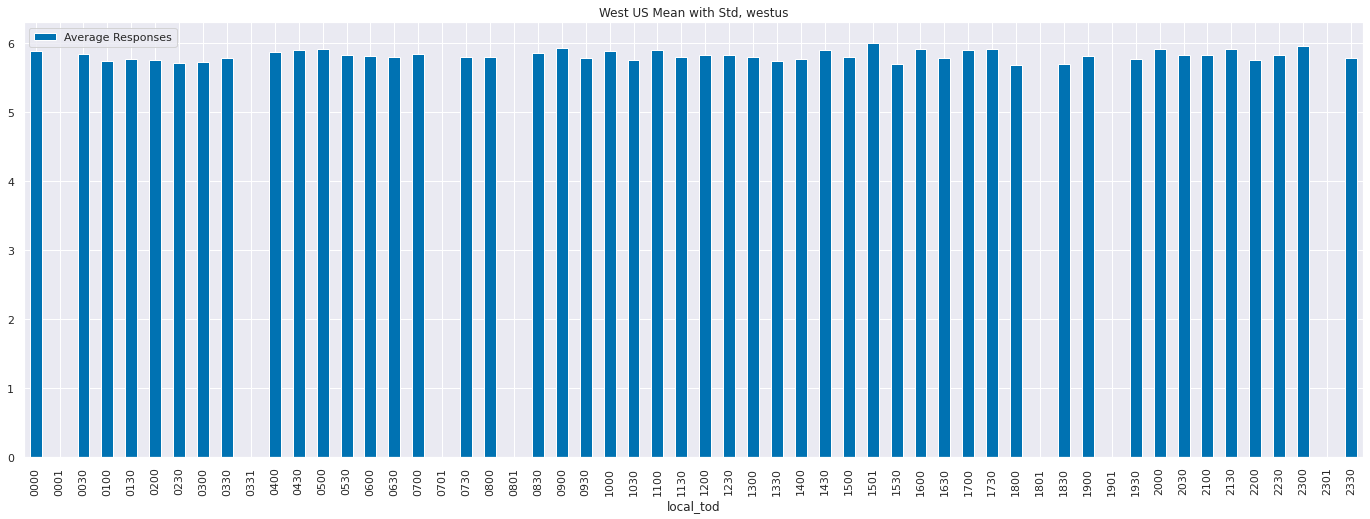

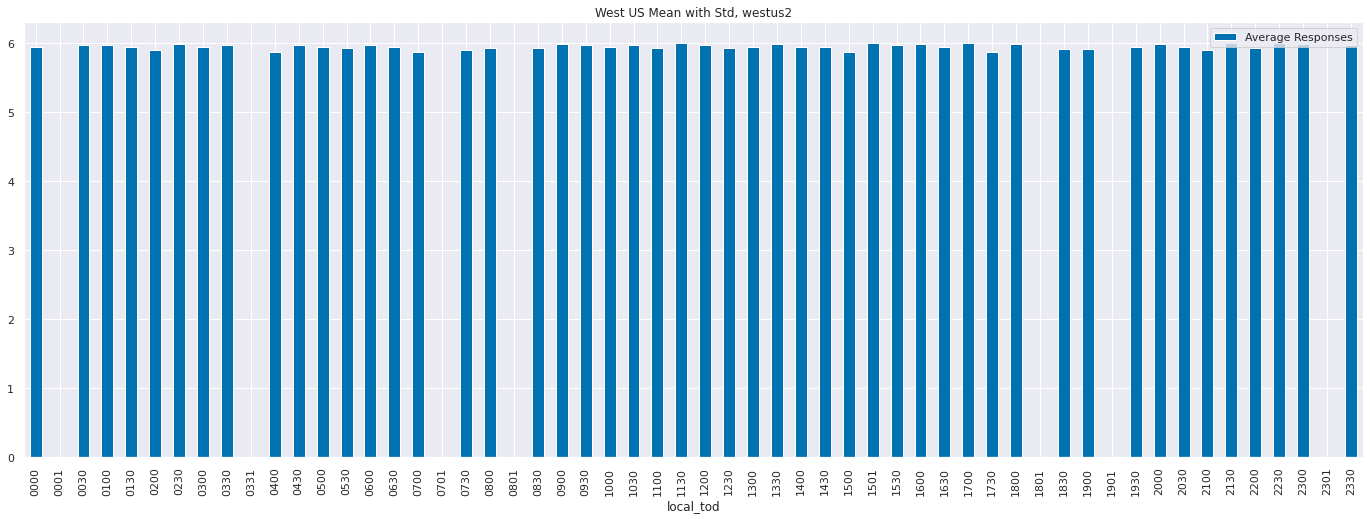

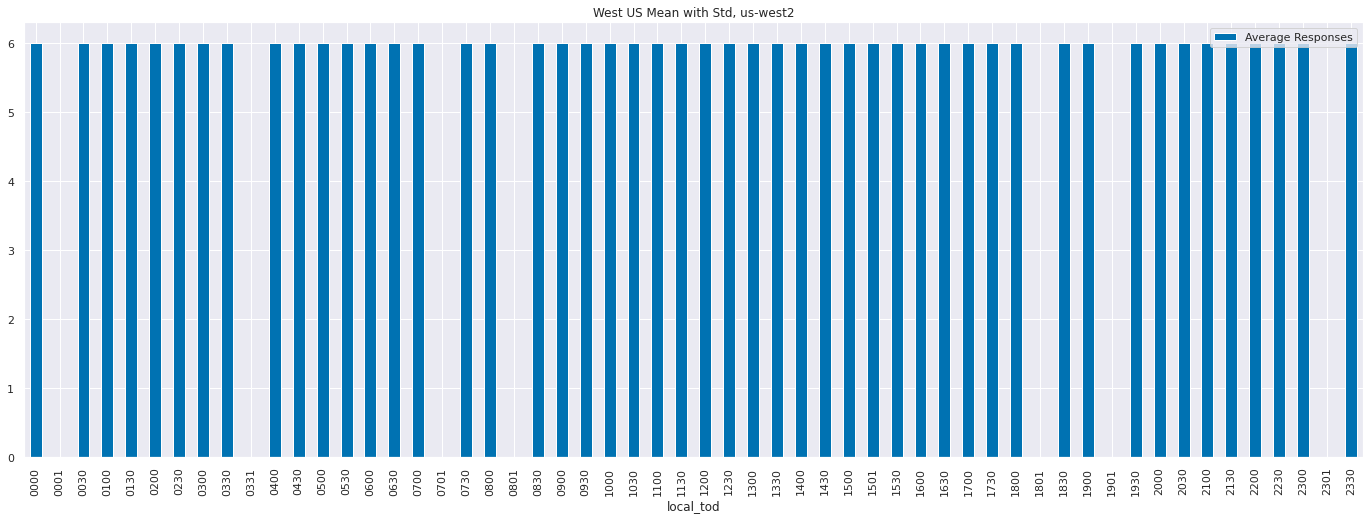

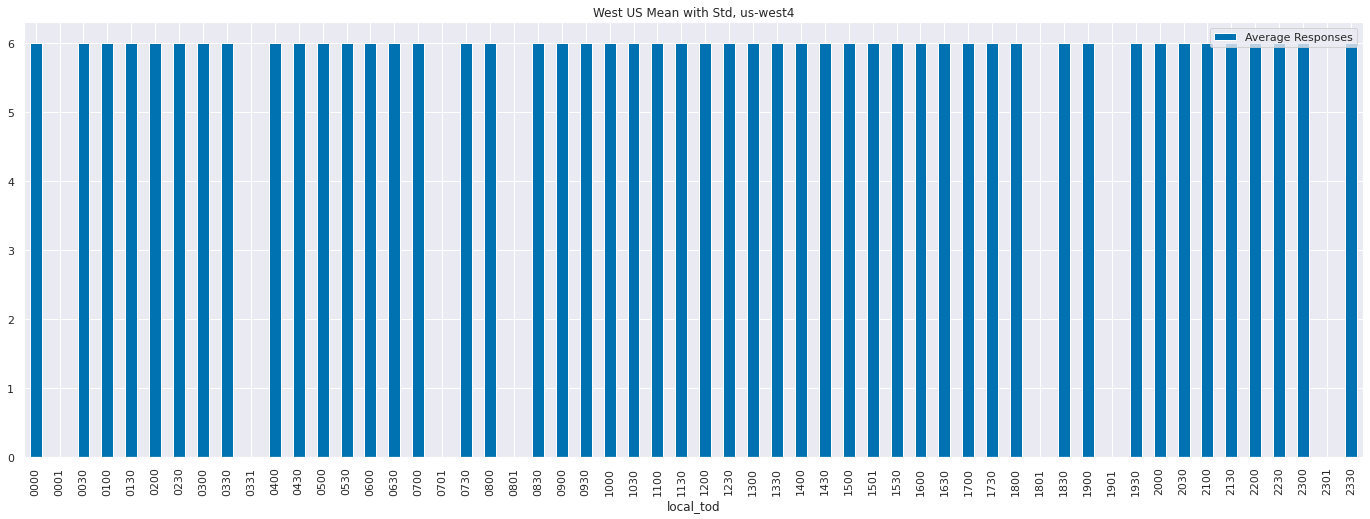

In [45]:
measure_group_region_df = dataset.groupby('measure group')['region'].unique()
for mg in measure_group_region_df.index:
    regions = measure_group_region_df.loc[mg]
    for region in regions:
        fig, ax = plt.subplots(figsize=(24,8))
        df = avg_reponses_df[avg_reponses_df['region'] == region]
        df.plot(title=f'{mg} Mean with Std, {region}', kind='bar',  ax=ax)
        plt.show()
        plt.close()

In [46]:
dataset['driver_invocation'].dtype

dtype('<M8[ns]')

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose
def decompose(dataset, provider, region):
  df = dataset[ (dataset['provider'] == provider) & (dataset['region'] == region) ].groupby(['driver_invocation'])[['runtime']].mean()
  with plt.rc_context():
      plt.rc("figure", figsize=(20,8))
      result = seasonal_decompose(df, model='additive' , period=48)
      
      fig, axis = plt.subplots(figsize=(24,12), sharex=True, nrows=4)

      axis[0].plot(result.observed)
      plt.setp(axis[0], ylabel='Observed')

      axis[1].plot(result.resid)
      plt.setp(axis[1], ylabel='Residuals')

      axis[2].plot(result.trend)
      plt.setp(axis[2], ylabel='Trend')

      axis[3].plot(result.seasonal)
      plt.setp(axis[3], ylabel='Seasonal')

      hours = mdates.HourLocator(interval=12) #or use interval
      hours.MAXTICKS = 3392

      h_fmt = mdates.DateFormatter('%a %H')

      axis[0].xaxis.set_major_locator(hours)
      axis[0].xaxis.set_major_formatter(h_fmt)

      axis[1].xaxis.set_major_locator(hours)
      axis[1].xaxis.set_major_formatter(h_fmt)

      axis[2].xaxis.set_major_locator(hours)
      axis[2].xaxis.set_major_formatter(h_fmt)

      axis[3].xaxis.set_major_locator(hours)
      axis[3].xaxis.set_major_formatter(h_fmt)

      fig.autofmt_xdate()

      fig.suptitle(f"Decomposition for {provider} - {region}")

      plt.show()
      plt.close()

      return result

In [48]:
# decom_df = dataset
# decom_df['driver_invocation'] = pd.DatetimeIndex(decom_df['driver_invocation'])
# decom_df = decom_df.set_index('driver_invocation')


In [49]:
def runtime(dataset, provider, region):
    df = dataset[ (dataset['provider'] == provider) & (dataset['region'] == region) ].groupby(['driver_invocation'])[['runtime']].mean()
    return df

In [50]:
# runtime(decom_df, 'AZURE', 'japaneast')

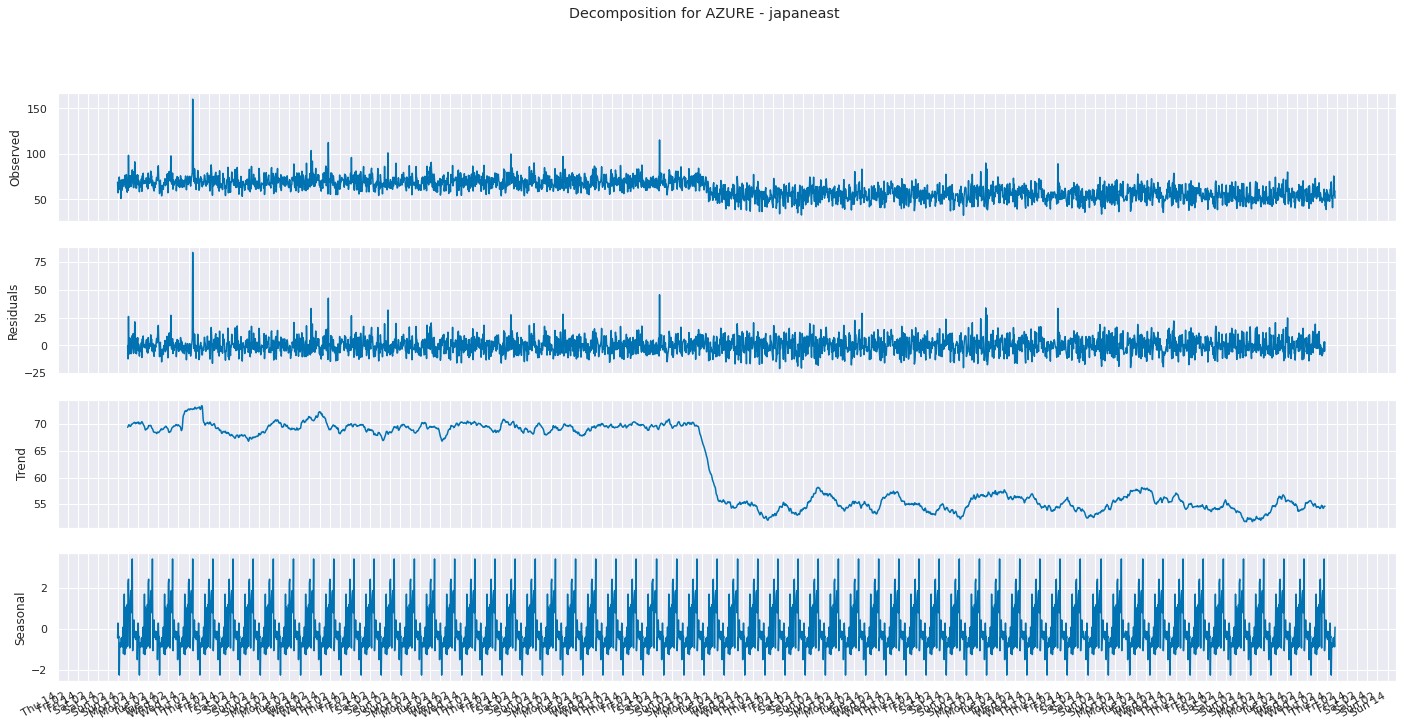

In [51]:
# dataset2 = dataset.set_index('driver_invocation')
result = decompose(dataset, 'AZURE', 'japaneast')

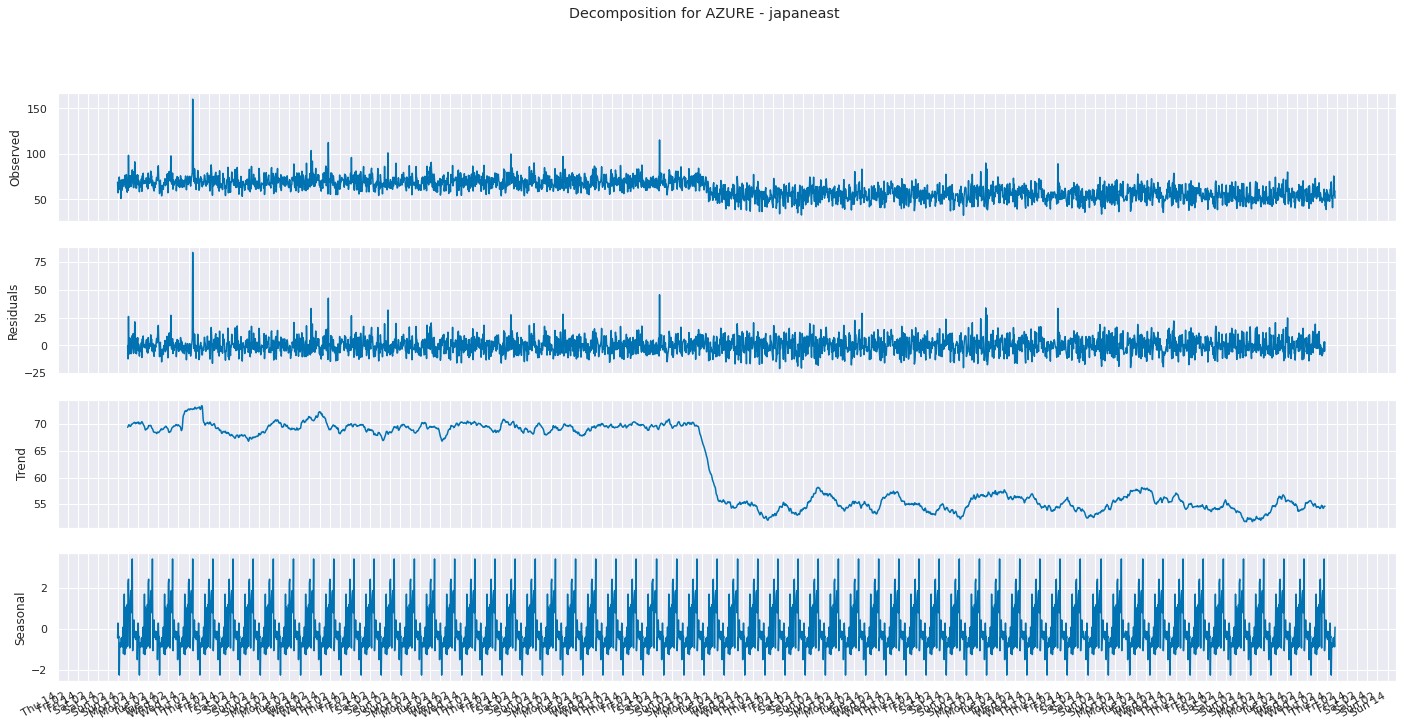

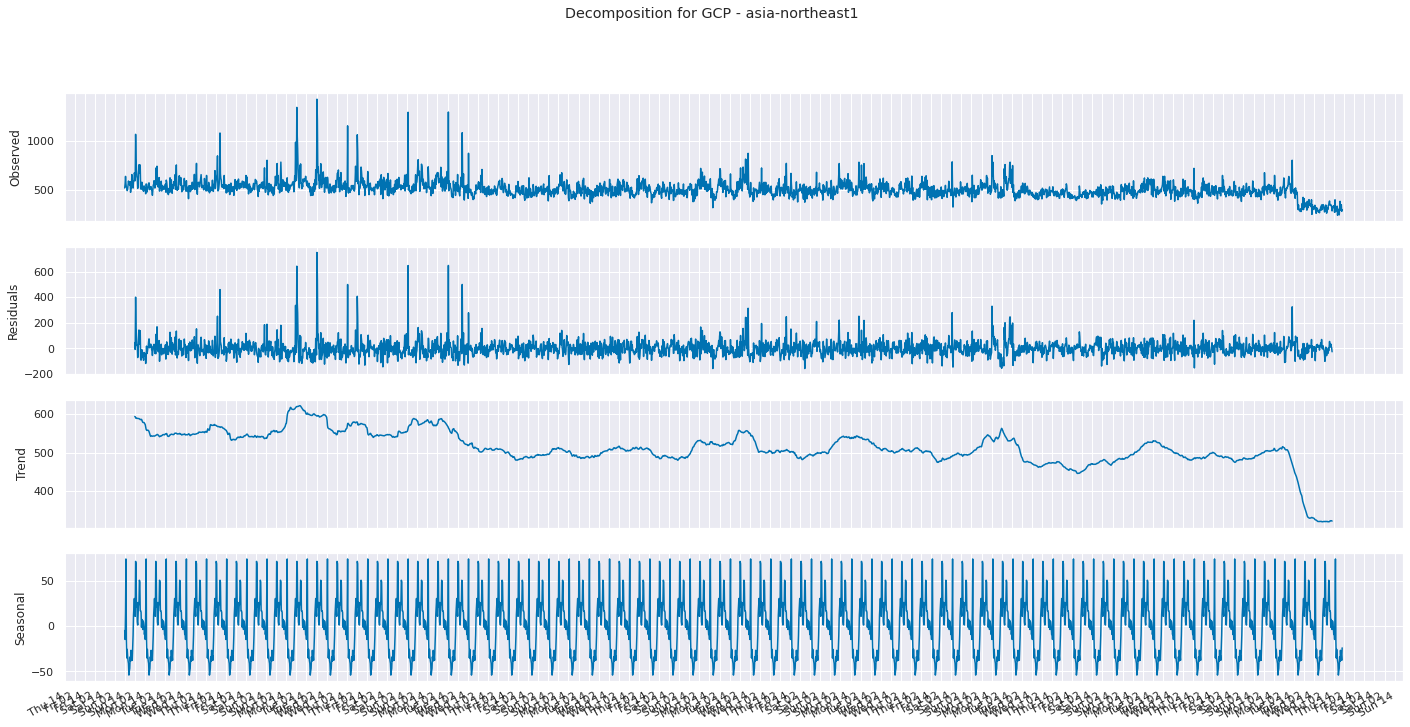

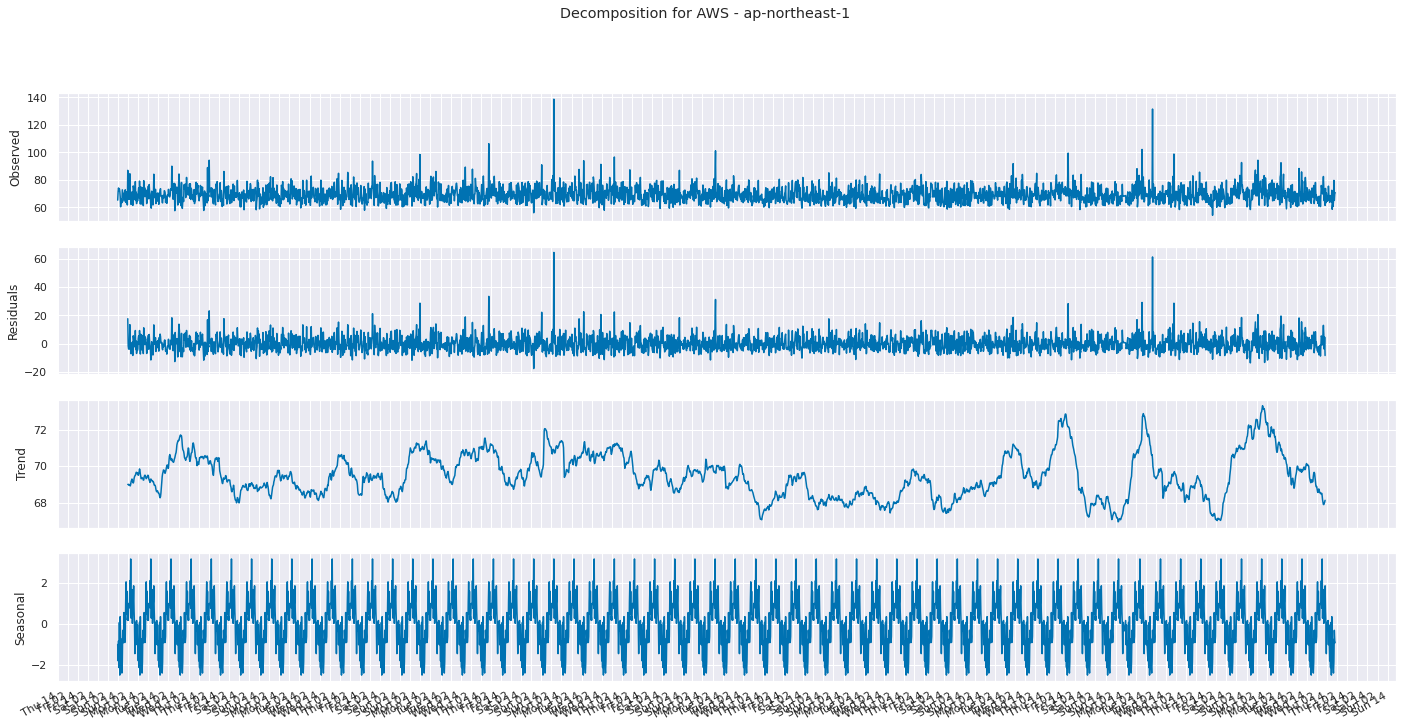

In [52]:
decompose(dataset, 'AZURE', 'japaneast')
decompose(dataset, 'GCP', 'asia-northeast1')
decompose(dataset, 'AWS', 'ap-northeast-1')

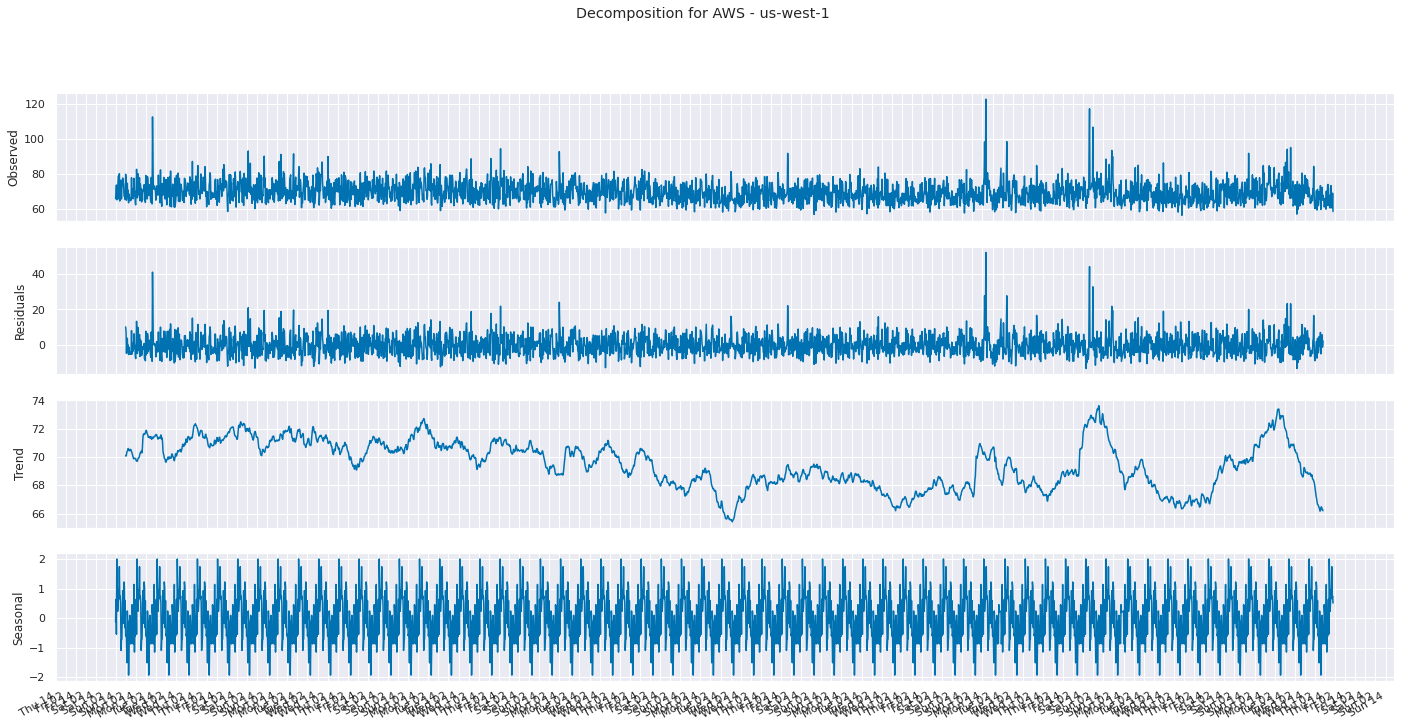

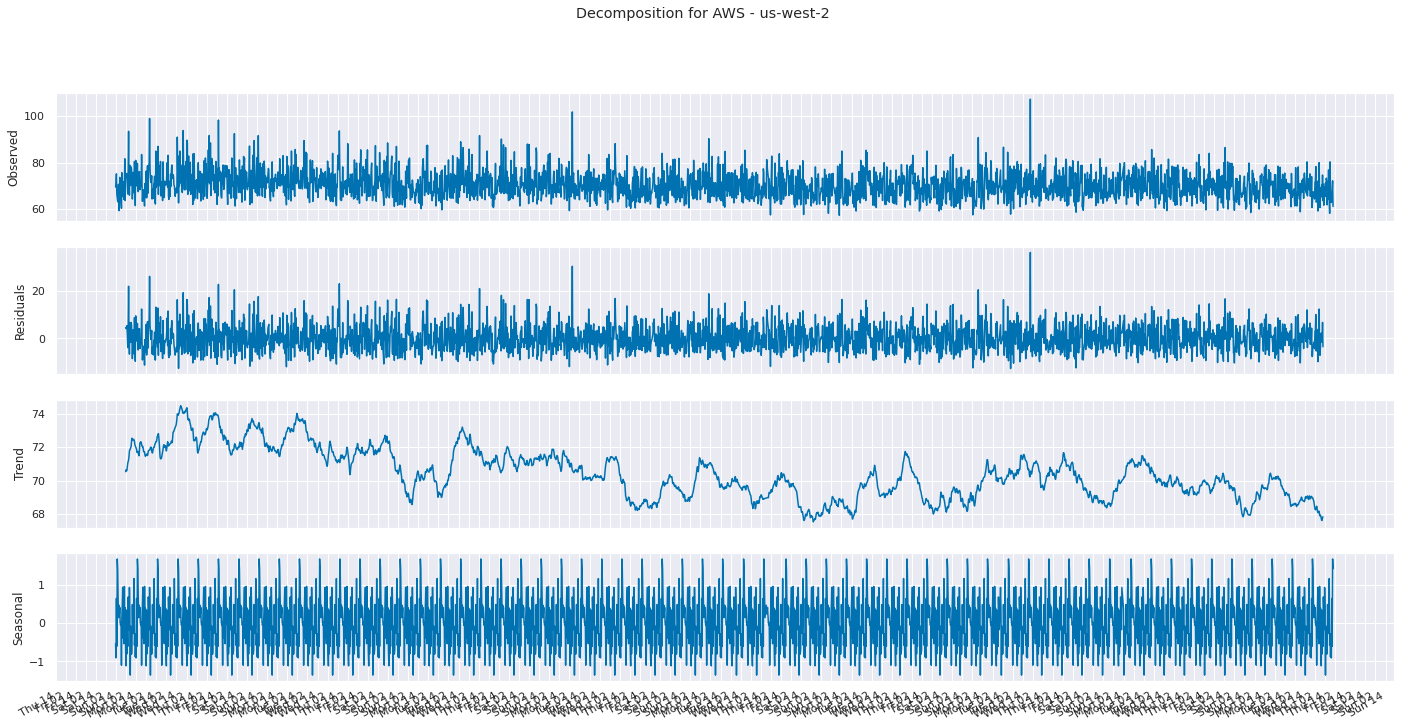

In [53]:
decompose(dataset, 'AWS', 'us-west-1')
decompose(dataset, 'AWS', 'us-west-2')

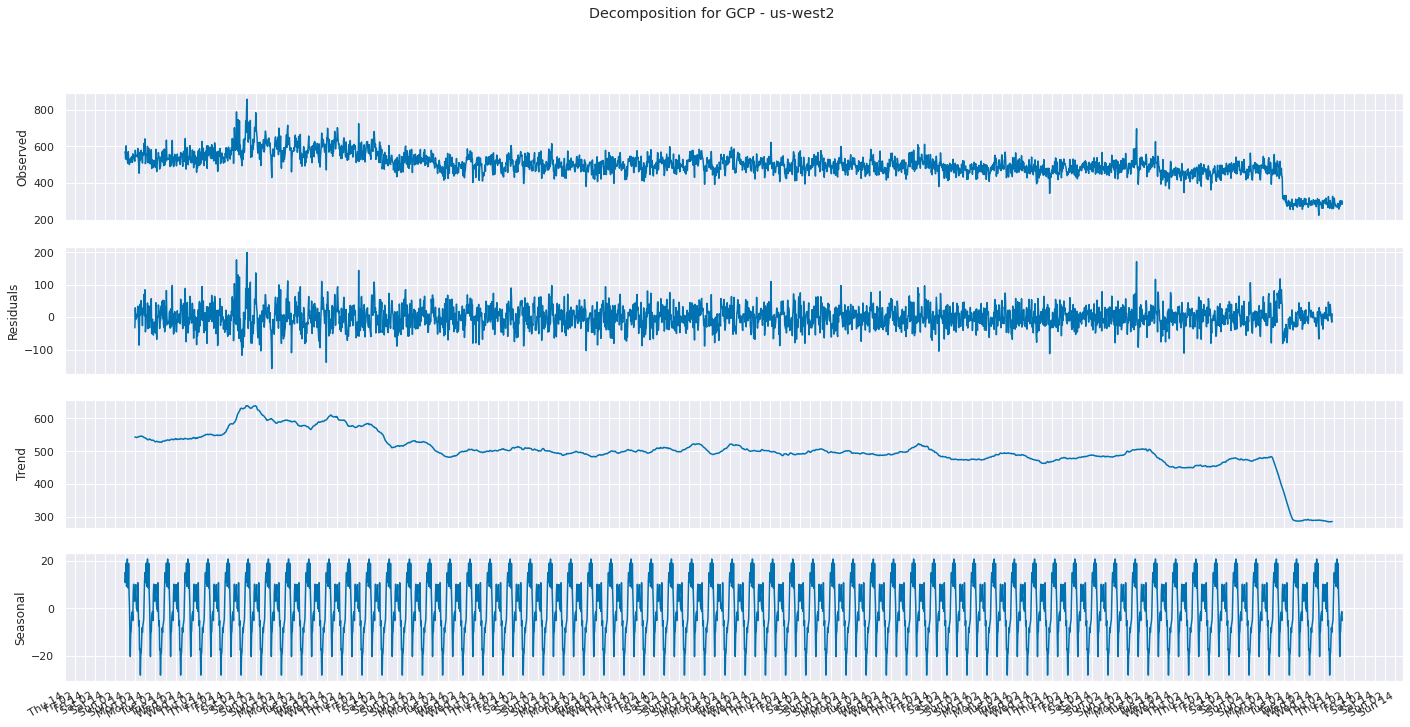

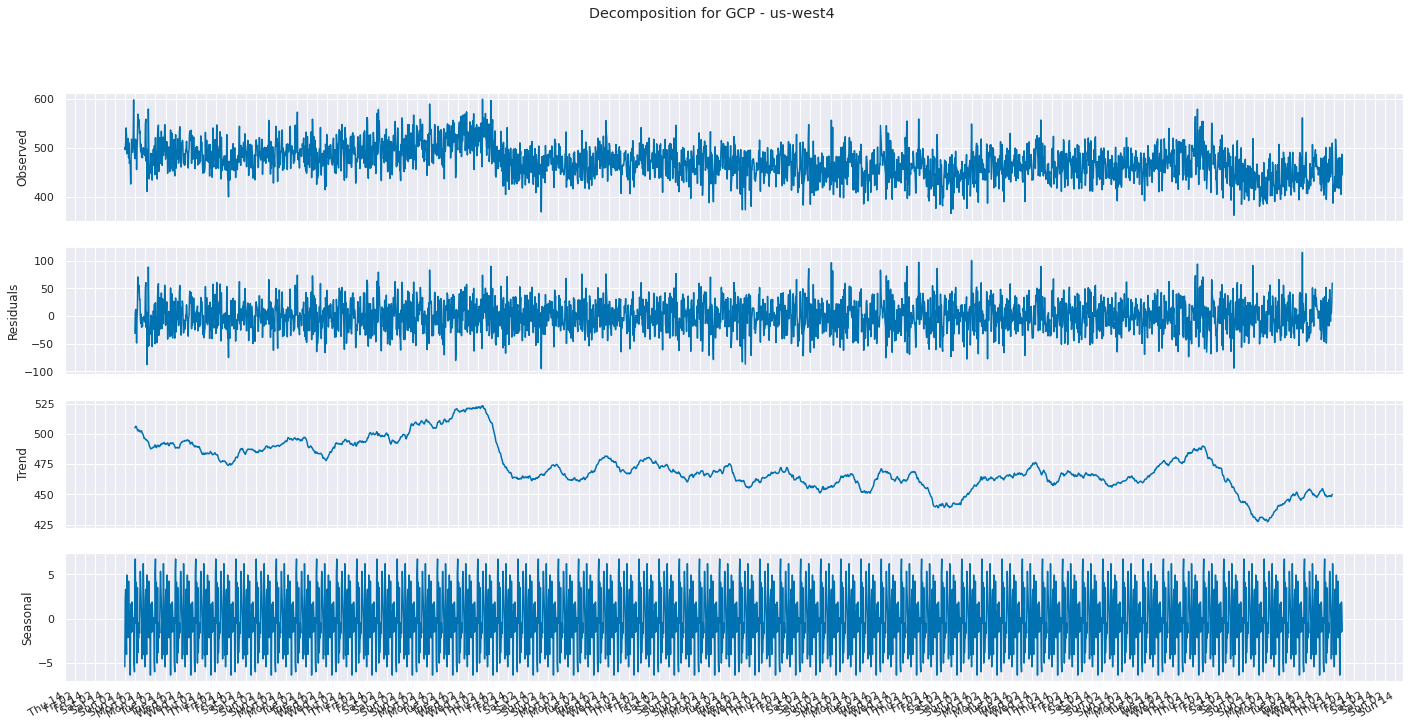

In [54]:
decompose(dataset, 'GCP', 'us-west2')
decompose(dataset, 'GCP', 'us-west4')